# Copyright Netherlands eScience Center <br>
** Function     : Predict the Spatial Sea Ice Concentration with BayesConvLSTM at weekly time scale** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2020.08.28 ** <br>
** Last Update  : 2020.08.28 ** <br>
** Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib **<br>
Description     : This notebook serves to predict the Arctic sea ice using deep learning. The Bayesian Convolutional Long Short Time Memory neural network is used to deal with this spatial-temporal sequence problem. We use Pytorch as the deep learning framework. <br>
<br>
** Here we predict sea ice concentration with one extra relevant field from either ocean or atmosphere to test the predictor.** <br>

Return Values   : Time series and figures <br>

The regionalization adopted here follows that of the MASIE (Multisensor Analyzed Sea Ice Extent) product available from the National Snow and Ice Data Center:<br>
https://nsidc.org/data/masie/browse_regions<br>
It is given by paper J.Walsh et. al., 2019. Benchmark seasonal prediction skill estimates based on regional indices.<br>

In [1]:
%matplotlib inline

import sys
import numbers
import csv
# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import sklearn
#import scipy
import torch
import torch.nn.functional

#sys.path.append(os.path.join('C:','Users','nosta','ML4Climate','Scripts','DLACs'))
#sys.path.append("C:\\Users\\nosta\\ML4Climate\\Scripts\\DLACs")
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/Scripts/DLACs")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF
import dlacs.metric

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

** Data ** <br>
Time span of each product included: <br>
** Reanalysis ** <br>
- **ERA-Interim** 1979 - 2017 (ECMWF)
- **ORAS4**       1958 - 2017 (ECMWF)

Alternative (not in use yet) <br>
** Reanalysis ** <br>
- **MERRA2**      1980 - 2016 (NASA)
- **JRA55**       1979 - 2015 (JMA)
- **GLORYS2V3**   1993 - 2014 (Mercartor Ocean)
- **SODA3**       1980 - 2015
- **PIOMASS**     1980 - 2015

** Observations ** <br>
- **NSIDC**       1958 - 2017 

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# data path for input fields
datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ERA-Interim'
#datapath_ERAI = 'H:\\Creator_Zone\\Core_Database_DeepLearn\\ERA-Interim'
datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ORAS4'
#datapath_ORAS4 = 'H:\\Creator_Zone\\Core_Database_DeepLearn\\ORAS4'
datapath_ORAS4_mask = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ORAS4'
#datapath_ORAS4_mask = 'H:\\Creator_Zone\\Core_Database_DeepLearn\\ORAS4'
#datapath_PIOMASS = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/PIOMASS'
#datapath_PIOMASS = 'H:\\Creator_Zone\\Core_Database_AMET_OMET_reanalysis\\PIOMASS'
#datapath_clim_index = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/Climate_index'
#datapath_clim_index = 'F:\\PhD_essential\\Core_Database_AMET_OMET_reanalysis\\Climate_index'
# data path for forecast fields
pred_bayesconvlstm_path = '/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/PredictArctic/BayesMaps/HyperParam/validAll/ohc/ens'
pred_convlstm_path = '/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/PredictArctic/Maps/Barents/SenseParam/valid_All/ohc/pred'
pred_NCEP_ensemble_path = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/S2S/NCEPens'
# data path for output
output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/PredictArctic/BayesMaps'
#output_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps'

In [4]:
if __name__=="__main__":
    print ('*********************** get the key to the datasets *************************')
    # weekly variables on ERAI grid
    dataset_ERAI_fields_sic = Dataset(os.path.join(datapath_ERAI,
                                      'sic_weekly_erai_1979_2017.nc'))
#     dataset_ERAI_fields_slp = Dataset(os.path.join(datapath_ERAI,
#                                       'slp_weekly_erai_1979_2017.nc'))
#     dataset_ERAI_fields_t2m = Dataset(os.path.join(datapath_ERAI,
#                                       't2m_weekly_erai_1979_2017.nc'))
#     dataset_ERAI_fields_z500 = Dataset(os.path.join(datapath_ERAI,
#                                        'z500_weekly_erai_1979_2017.nc'))
#     dataset_ERAI_fields_z850 = Dataset(os.path.join(datapath_ERAI,
#                                        'z850_weekly_erai_1979_2017.nc'))
#     dataset_ERAI_fields_uv10m = Dataset(os.path.join(datapath_ERAI,
#                                        'uv10m_weekly_erai_1979_2017.nc'))
#     dataset_ERAI_fields_rad = Dataset(os.path.join(datapath_ERAI,
#                                         'rad_flux_weekly_erai_1979_2017.nc'))
    #dataset_PIOMASS_siv = Dataset(os.path.join(datapath_PIOMASS,
    #                             'siv_monthly_PIOMASS_1979_2017.nc'))
    # OHC interpolated on ERA-Interim grid
    dataset_ORAS4_OHC = Dataset(os.path.join(datapath_ORAS4,
                                'ohc_monthly_oras2erai_1978_2017.nc'))
#     dataset_index = Dataset(os.path.join(datapath_clim_index,
#                             'index_climate_monthly_regress_1950_2017.nc'))
    #dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
    #                                  'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    # mask
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
    print ('*********************** extract variables *************************')
    #################################################################################
    #########                        data gallery                           #########
    #################################################################################
    # we use time series from 1979 to 2016 (468 months in total)
    # training data: 1979 - 2013
    # validation: 2014 - 2016
    # variables list:
    # SIC (ERA-Interim) / SIV (PIOMASS) / SST (ERA-Interim) / ST (ERA-Interim) / OHC (ORAS4) / AO-NAO-AMO-NINO3.4 (NOAA)
    # integrals from spatial fields cover the area from 20N - 90N (4D fields [year, month, lat, lon])
    # *************************************************************************************** #
    # SIC (ERA-Interim) - benckmark
    SIC_ERAI = dataset_ERAI_fields_sic.variables['sic'][:,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI = dataset_ERAI_fields_sic.variables['year'][:]
    week_ERAI = dataset_ERAI_fields_sic.variables['week'][:]
    latitude_ERAI = dataset_ERAI_fields_sic.variables['latitude'][:]
    longitude_ERAI = dataset_ERAI_fields_sic.variables['longitude'][:]
    # T2M (ERA-Interim)
#     T2M_ERAI = dataset_ERAI_fields_t2m.variables['t2m'][:,:,:,:] # 4D fields [year, week, lat, lon]
#     year_ERAI_t2m = dataset_ERAI_fields_t2m.variables['year'][:]
#     week_ERAI_t2m = dataset_ERAI_fields_t2m.variables['week'][:]
#     latitude_ERAI_t2m = dataset_ERAI_fields_t2m.variables['latitude'][:]
#     longitude_ERAI_t2m = dataset_ERAI_fields_t2m.variables['longitude'][:]
    # SLP (ERA-Interim)
#     SLP_ERAI = dataset_ERAI_fields_slp.variables['slp'][:,:,:,:] # 4D fields [year, week, lat, lon]
#     year_ERAI_slp = dataset_ERAI_fields_slp.variables['year'][:]
#     week_ERAI_slp = dataset_ERAI_fields_slp.variables['week'][:]
#     latitude_ERAI_slp = dataset_ERAI_fields_slp.variables['latitude'][:]
#     longitude_ERAI_slp = dataset_ERAI_fields_slp.variables['longitude'][:]
    # Z500 (ERA-Interim)
#     Z500_ERAI = dataset_ERAI_fields_z500.variables['z'][:,:,:,:] # 4D fields [year, week, lat, lon]
#     year_ERAI_z500 = dataset_ERAI_fields_z500.variables['year'][:]
#     week_ERAI_z500 = dataset_ERAI_fields_z500.variables['week'][:]
#     latitude_ERAI_z500 = dataset_ERAI_fields_z500.variables['latitude'][:]
#     longitude_ERAI_z500 = dataset_ERAI_fields_z500.variables['longitude'][:]
    # Z850 (ERA-Interim)
#     Z850_ERAI = dataset_ERAI_fields_z850.variables['z'][:,:,:,:] # 4D fields [year, week, lat, lon]
#     year_ERAI_z850 = dataset_ERAI_fields_z850.variables['year'][:]
#     week_ERAI_z850 = dataset_ERAI_fields_z850.variables['week'][:]
#     latitude_ERAI_z850 = dataset_ERAI_fields_z850.variables['latitude'][:]
#     longitude_ERAI_z850 = dataset_ERAI_fields_z850.variables['longitude'][:]
    # UV10M (ERA-Interim)
#     U10M_ERAI = dataset_ERAI_fields_uv10m.variables['u10m'][:,:,:,:] # 4D fields [year, week, lat, lon]
#     V10M_ERAI = dataset_ERAI_fields_uv10m.variables['v10m'][:,:,:,:] # 4D fields [year, week, lat, lon]
#     year_ERAI_uv10m = dataset_ERAI_fields_uv10m.variables['year'][:]
#     week_ERAI_uv10m = dataset_ERAI_fields_uv10m.variables['week'][:]
#     latitude_ERAI_uv10m = dataset_ERAI_fields_uv10m.variables['latitude'][:]
#     longitude_ERAI_uv10m = dataset_ERAI_fields_uv10m.variables['longitude'][:]
    # SFlux (ERA-Interim)
#     SFlux_ERAI = dataset_ERAI_fields_rad.variables['SFlux'][:,:,:,:] # 4D fields [year, week, lat, lon]
#     year_ERAI_SFlux = dataset_ERAI_fields_rad.variables['year'][:]
#     week_ERAI_SFlux = dataset_ERAI_fields_rad.variables['week'][:]
#     latitude_ERAI_SFlux = dataset_ERAI_fields_rad.variables['latitude'][:]
#     longitude_ERAI_SFlux = dataset_ERAI_fields_rad.variables['longitude'][:]
    #SIV (PIOMASS)
    #SIV_PIOMASS = dataset_PIOMASS_siv.variables['SIV'][:-12]
    #year_SIV = dataset_PIOMASS_siv.variables['year'][:-1]
    # OHC (ORAS4)
    # from 1978 - 2017 (for interpolation) / from 90 N upto 40 N
    OHC_300_ORAS4 = dataset_ORAS4_OHC.variables['OHC'][:,:,:67,:]/1000 # unit Peta Joule
    latitude_ORAS4 = dataset_ORAS4_OHC.variables['latitude'][:]
    longitude_ORAS4 = dataset_ORAS4_OHC.variables['longitude'][:]
    mask_OHC = np.ma.getmask(OHC_300_ORAS4[0,0,:,:])
    # AO-NAO-AMO-NINO3.4 (NOAA)
#     AO = dataset_index.variables['AO'][348:-1] # from 1979 - 2017
#     NAO = dataset_index.variables['NAO'][348:-1]
#     NINO = dataset_index.variables['NINO'][348:-1]
#     AMO = dataset_index.variables['AMO'][348:-1]
#     PDO = dataset_index.variables['PDO'][348:-1]

*********************** get the key to the datasets *************************
*********************** extract variables *************************


In [9]:
    # first check of grid
    print(latitude_ERAI)
    print(longitude_ERAI)
    print(longitude_ORAS4)

[89.5  88.75 88.   87.25 86.5  85.75 85.   84.25 83.5  82.75 82.   81.25
 80.5  79.75 79.   78.25 77.5  76.75 76.   75.25 74.5  73.75 73.   72.25
 71.5  70.75 70.   69.25 68.5  67.75 67.   66.25 65.5  64.75 64.   63.25
 62.5  61.75 61.   60.25 59.5  58.75 58.   57.25 56.5  55.75 55.   54.25
 53.5  52.75 52.   51.25 50.5  49.75 49.   48.25 47.5  46.75 46.   45.25
 44.5  43.75 43.   42.25 41.5  40.75 40.  ]
[-180.   -179.25 -178.5  -177.75 -177.   -176.25 -175.5  -174.75 -174.
 -173.25 -172.5  -171.75 -171.   -170.25 -169.5  -168.75 -168.   -167.25
 -166.5  -165.75 -165.   -164.25 -163.5  -162.75 -162.   -161.25 -160.5
 -159.75 -159.   -158.25 -157.5  -156.75 -156.   -155.25 -154.5  -153.75
 -153.   -152.25 -151.5  -150.75 -150.   -149.25 -148.5  -147.75 -147.
 -146.25 -145.5  -144.75 -144.   -143.25 -142.5  -141.75 -141.   -140.25
 -139.5  -138.75 -138.   -137.25 -136.5  -135.75 -135.   -134.25 -133.5
 -132.75 -132.   -131.25 -130.5  -129.75 -129.   -128.25 -127.5  -126.75
 -126.   -125

In [6]:
    #################################################################################
    ###########                 global land-sea mask                      ###########
    #################################################################################
    sea_ice_mask_global = np.ones((len(latitude_ERAI),len(longitude_ERAI)),dtype=float)
    sea_ice_mask_global[SIC_ERAI[0,0,:,:]==-1] = 0
    #################################################################################
    ###########                regionalization sea mask                   ###########
    #################################################################################
    print ('*********************** create mask *************************')
    # W:-156 E:-124 N:80 S:67
    mask_Beaufort = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-180 E:-156 N:80 S:66
    mask_Chukchi = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:146 E:180 N:80 S:67
    mask_EastSiberian = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:100 E:146 N:80 S:67
    mask_Laptev = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:60 E:100 N:80 S:67
    mask_Kara = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:18 E:60 N:80 S:64
    mask_Barents = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-44 E:18 N:80 S:55
    mask_Greenland = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-180 E:180 N:90 S:80
    mask_CenArctic = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    print ('*********************** calc mask *************************')
    mask_Beaufort[13:31,32:76] = 1

    mask_Chukchi[13:32,0:32] = 1
    mask_Chukchi[13:32,-1] = 1

    mask_EastSiberian[13:31,434:479] = 1

    mask_Laptev[13:31,374:434] = 1

    mask_Kara[13:31,320:374] = 1

    mask_Barents[13:36,264:320] = 1

    mask_Greenland[13:47,179:264] = 1
    mask_Greenland[26:47,240:264] = 0

    mask_CenArctic[:13,:] = 1
    print ('*********************** packing *************************')
    mask_dict = {'Beaufort': mask_Beaufort[:,:],
                 'Chukchi': mask_Chukchi[:,:],
                 'EastSiberian': mask_EastSiberian[:,:],
                 'Laptev': mask_Laptev[:,:],
                 'Kara': mask_Kara[:,:],
                 'Barents': mask_Barents[:,:],
                 'Greenland': mask_Greenland[:,:],
                 'CenArctic': mask_CenArctic[:,:]}
    seas_namelist = ['Beaufort','Chukchi','EastSiberian','Laptev',
                     'Kara', 'Barents', 'Greenland','CenArctic']

*********************** create mask *************************
*********************** calc mask *************************
*********************** packing *************************


In [7]:
    #################################################################################
    ########                  temporal interpolation matrix                  ########
    #################################################################################
    # interpolate from monthly to weekly
    # original monthly data will be taken as the last week of the month
    OHC_300_ORAS4_weekly_series = np.zeros(SIC_ERAI.reshape(len(year_ERAI)*48,len(latitude_ERAI),len(longitude_ERAI)).shape,
                                           dtype=float)
    OHC_300_ORAS4_series= dlacs.preprocess.operator.unfold(OHC_300_ORAS4)
    # calculate the difference between two months
    OHC_300_ORAS4_deviation_series = (OHC_300_ORAS4_series[1:,:,:] - OHC_300_ORAS4_series[:-1,:,:]) / 4
    for i in np.arange(4):
        OHC_300_ORAS4_weekly_series[3-i::4,:,:] = OHC_300_ORAS4_series[12:,:,:] - i * OHC_300_ORAS4_deviation_series[11:,:,:]

In [8]:
    print ('******************  calculate extent from spatial fields  *******************')
    # size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_ERAI /
                                            360) / len(longitude_ERAI)
    dy = np.pi * constant['R'] / 480
    # calculate the sea ice area
    SIC_ERAI_area = np.zeros(SIC_ERAI.shape, dtype=float)
#     SFlux_ERAI_area = np.zeros(SFlux_ERAI.shape, dtype=float)
    for i in np.arange(len(latitude_ERAI[:])):
        # change the unit to terawatt
        SIC_ERAI_area[:,:,i,:] = SIC_ERAI[:,:,i,:]* dx[i] * dy / 1E+6 # unit km2
#         SFlux_ERAI_area[:,:,i,:] = SFlux_ERAI[:,:,i,:]* dx[i] * dy / 1E+12 # unit TeraWatt
    SIC_ERAI_area[SIC_ERAI_area<0] = 0 # switch the mask from -1 to 0
    print ('================  reshape input data into time series  =================')
    SIC_ERAI_area_series = dlacs.preprocess.operator.unfold(SIC_ERAI_area)
#     T2M_ERAI_series = dlacs.preprocess.operator.unfold(T2M_ERAI)
#     SLP_ERAI_series = dlacs.preprocess.operator.unfold(SLP_ERAI)
#     Z500_ERAI_series = dlacs.preprocess.operator.unfold(Z500_ERAI)
#     Z850_ERAI_series = dlacs.preprocess.operator.unfold(Z850_ERAI)
#     U10M_ERAI_series = dlacs.preprocess.operator.unfold(U10M_ERAI)
#     V10M_ERAI_series = dlacs.preprocess.operator.unfold(V10M_ERAI)
#     SFlux_ERAI_area_series = dlacs.preprocess.operator.unfold(SFlux_ERAI_area)

******************  calculate extent from spatial fields  *******************
================  reshape input data into time series  =================


In [9]:
    print ('******************  choose the fields from target region  *******************')
    # select land-sea mask
    sea_ice_mask_barents = sea_ice_mask_global[12:36,264:320]
    print ('******************  choose the fields from target region  *******************')
    # select the area between greenland and ice land for instance 60-70 N / 44-18 W
    sic_exp = SIC_ERAI_area_series[:,12:36,264:320]
#     t2m_exp = T2M_ERAI_series[:,12:36,264:320]
#     slp_exp = SLP_ERAI_series[:,12:36,264:320]
#     z500_exp = Z500_ERAI_series[:,12:36,264:320]
#     z850_exp = Z850_ERAI_series[:,12:36,264:320]
#     u10m_exp = U10M_ERAI_series[:,12:36,264:320]
#     v10m_exp = V10M_ERAI_series[:,12:36,264:320]
#     sflux_exp = SFlux_ERAI_area_series[:,12:36,264:320]
    ohc_exp = OHC_300_ORAS4_weekly_series[:,12:36,264:320]
    print(sic_exp.shape)
#     print(t2m_exp.shape)
#     print(slp_exp.shape)
#     print(z500_exp.shape)
#     print(u10m_exp.shape)
#     print(v10m_exp.shape)
#     print(sflux_exp.shape)
    print(ohc_exp.shape)
    print(latitude_ERAI[12:36])
    print(longitude_ERAI[264:320])
    print(latitude_ORAS4[12:36])
    print(longitude_ORAS4[264:320])
    #print(latitude_ERAI[26:40])
    #print(longitude_ERAI[180:216])
    #print(sic_exp[:])
    lat_cut = latitude_ERAI[12:36]
    lon_cut = longitude_ERAI[264:320]

******************  choose the fields from target region  *******************
******************  choose the fields from target region  *******************
(1872, 24, 56)
(1872, 24, 56)
[80.5  79.75 79.   78.25 77.5  76.75 76.   75.25 74.5  73.75 73.   72.25
 71.5  70.75 70.   69.25 68.5  67.75 67.   66.25 65.5  64.75 64.   63.25]
[18.   18.75 19.5  20.25 21.   21.75 22.5  23.25 24.   24.75 25.5  26.25
 27.   27.75 28.5  29.25 30.   30.75 31.5  32.25 33.   33.75 34.5  35.25
 36.   36.75 37.5  38.25 39.   39.75 40.5  41.25 42.   42.75 43.5  44.25
 45.   45.75 46.5  47.25 48.   48.75 49.5  50.25 51.   51.75 52.5  53.25
 54.   54.75 55.5  56.25 57.   57.75 58.5  59.25]
[80.5  79.75 79.   78.25 77.5  76.75 76.   75.25 74.5  73.75 73.   72.25
 71.5  70.75 70.   69.25 68.5  67.75 67.   66.25 65.5  64.75 64.   63.25]
[18.   18.75 19.5  20.25 21.   21.75 22.5  23.25 24.   24.75 25.5  26.25
 27.   27.75 28.5  29.25 30.   30.75 31.5  32.25 33.   33.75 34.5  35.25
 36.   36.75 37.5  38.25 39.   3

In [10]:
    print ('*******************  pre-processing  *********************')
    print ('=========================   normalize data   ===========================')
    sic_exp_norm = dlacs.preprocess.operator.normalize(sic_exp)
#     t2m_exp_norm = dlacs.preprocess.operator.normalize(t2m_exp)
#     slp_exp_norm = dlacs.preprocess.operator.normalize(slp_exp)
#     z500_exp_norm = dlacs.preprocess.operator.normalize(z500_exp)
#     z850_exp_norm = dlacs.preprocess.operator.normalize(z850_exp)
#     u10m_exp_norm = dlacs.preprocess.operator.normalize(u10m_exp)
#     v10m_exp_norm = dlacs.preprocess.operator.normalize(v10m_exp)
#     sflux_exp_norm = dlacs.preprocess.operator.normalize(sflux_exp)
    ohc_exp_norm = dlacs.preprocess.operator.normalize(ohc_exp)
    print('================  save the normalizing factor  =================')
    sic_max = np.amax(sic_exp)
    sic_min = np.amin(sic_exp)
    print(sic_max,"km2")
    print(sic_min,"km2")
    print ('*******************  cross validation and testing data  *********************')
    # take 10% data as cross-validation data
    cross_valid_year = 0
    # take 10% years as testing data
    test_year = 3

*******************  pre-processing  *********************
=========================   normalize data   ===========================
================  save the normalizing factor  =================
1565.2049481856002 km2
0.0 km2
*******************  cross validation and testing data  *********************


# Postprocessing <br>
** We examine the forecasts by BayesConvLSTM. ** <br>

In [11]:
    print ('*******************  load ensemble data  *********************')
    sequence_len, height, width = sic_exp_norm.shape
    print ('*******************  parameter for check  *********************')
    choice_exp_norm = ohc_exp_norm
    # predict x steps ahead
    step_lead = 16 # unit week
    # number of ensembles
    ens = 20
    predictand = np.zeros((ens, test_year*48, step_lead, height, width),
                           dtype=float)
    # extend the dimension of sea ice mask
    sea_ice_mask_test_interim = np.repeat(sea_ice_mask_barents[np.newaxis,:,:],step_lead,0)
    sea_ice_mask_test = np.repeat(sea_ice_mask_test_interim[np.newaxis,:,:,:],test_year*48,0)
    for i in range(ens):
        dataset_pred = Dataset(os.path.join(pred_bayesconvlstm_path, 'BayesConvLSTM_SIC_param_validAll_pred_init_ens_{}.nc'.format(i)))
        predictand[i,:,:,:,:] = dataset_pred.variables['pred'][:]
        # correct the land cells in the prediction
        predictand[i,:,:,:,:] = predictand[i,:,:,:,:] * sea_ice_mask_test
    # correction for float point at 0
    predictand[predictand<0] = 0
    print(predictand.shape)
    predictand_median = np.median(predictand, 0)
    print ('*******************  load deterministic pred data  *********************')
    dataset_pred_determin = Dataset(os.path.join(pred_convlstm_path, 'pred_sic.nc'))
    predictand_determin = dataset_pred_determin.variables['pred'][:] * sea_ice_mask_test
    predictand_determin[predictand_determin<0] = 0.0
    print(predictand_determin.shape)

*******************  load ensemble data  *********************
*******************  parameter for check  *********************
(20, 144, 16, 24, 56)
*******************  load deterministic pred data  *********************
(144, 16, 24, 56)


In [17]:
    print ('*******************  load ensemble data  *********************')
    # compute climatology
    climatology = np.zeros((48, height, width),dtype=float)
    for i in range(48):
        climatology[i,:,:] = np.mean(sic_exp_norm[i::48,:,:],axis=0)
    # repeat this climatology and calculate the RMSE
    climatology_seq = np.tile(climatology,(test_year,1,1))
    
    # sea ice extent
    climatology_seq_sum = np.sum(np.sum(climatology_seq,2),1)

*******************  load ensemble data  *********************


*******************  Precheck predicted ice concentration at certain location **********************
Time series of sic at lat 76.75 lon 25.5
*******************  lead time 1  **********************


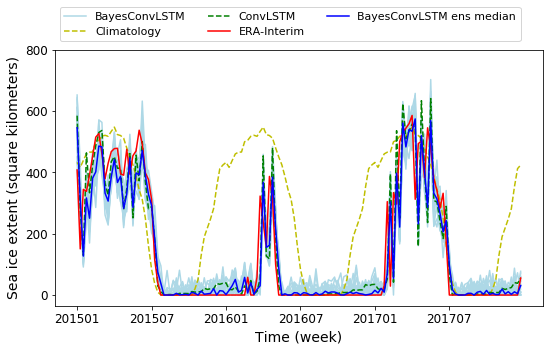

*******************  lead time 2  **********************


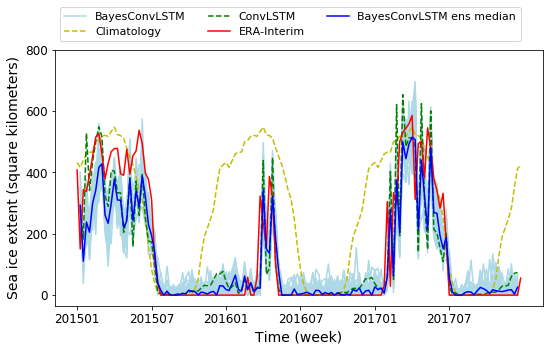

*******************  lead time 3  **********************


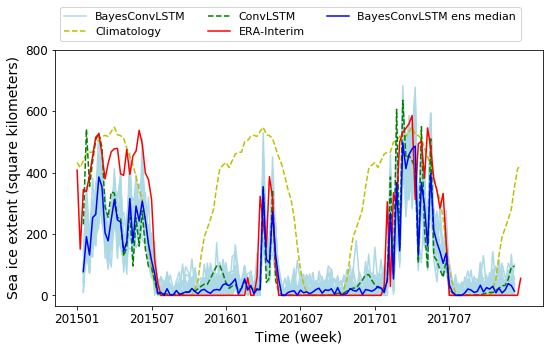

*******************  lead time 6  **********************


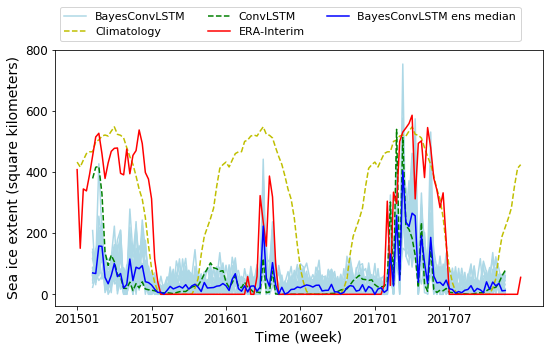

*******************  lead time 16  **********************


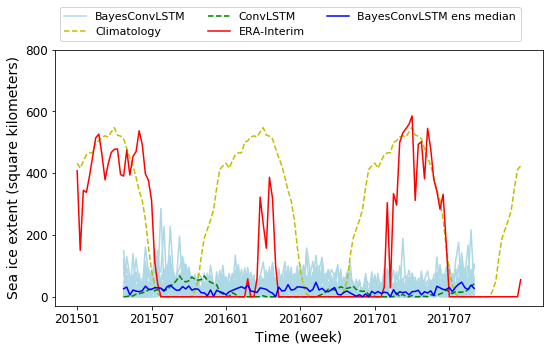

###   pin-point location   ###


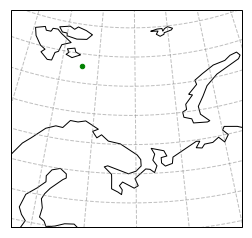

In [16]:
    #################################################################################
    ########   visualization of lead time dependent prediction - SIC point   ########
    #################################################################################
    index_plot = np.arange(test_year*12*4)
    index_plot_step = np.arange(test_year*12*4+1)
    year_index = np.arange(2015,2018,1)
    # check
    anchor_x = 10
    anchor_y = 5
    print ("*******************  Precheck predicted ice concentration at certain location **********************")
    print ("Time series of sic at lat {} lon {}".format(lat_cut[anchor_y], lon_cut[anchor_x]))
    print ("*******************  lead time 1  **********************")
    fig0 = plt.figure(figsize=(8,5))
    for i in range(ens):
        if i == 0:
            plt.plot(index_plot, predictand[i, :, 0, anchor_y, anchor_x] * sic_max,
                     color='lightblue', label="BayesConvLSTM")
        else:
            plt.plot(index_plot, predictand[i, :, 0, anchor_y, anchor_x] * sic_max, color='lightblue')
    
    plt.plot(index_plot, climatology_seq[:,anchor_y,anchor_x] * sic_max, 'y--', label="Climatology")
    plt.plot(index_plot, predictand_determin[:, 0, anchor_y,anchor_x] * sic_max, 'g--', label="ConvLSTM")
    plt.plot(index_plot, sic_exp_norm[-test_year*12*4:,anchor_y,anchor_x] * sic_max, 'r', label="ERA-Interim")
    plt.plot(index_plot, predictand_median[:, 0, anchor_y, anchor_x] * sic_max, 'b', label="BayesConvLSTM ens median")
    plt.xlabel('Time (week)',fontsize = 14)
    plt.ylabel('Sea ice extent (square kilometers)',fontsize = 14)
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201501', '201507', '201601', '201607',
                                                 '201701', '201707']),
               fontsize = 12)
    plt.yticks(np.arange(0,801,200), fontsize = 12)
    plt.legend(bbox_to_anchor=(0.01,1.10), loc="center left", borderaxespad=0, prop={'size': 11.0}, ncol=3)
    plt.tight_layout()
    plt.show()
    fig0.savefig(os.path.join(output_path,
                              'sic_ERAI_bayesconvlstm_pred_leadtime_1_lat{}_lon{}.png'.format(lat_cut[anchor_y], lon_cut[anchor_x])),dpi=150)
    plt.close()
    
    print ("*******************  lead time 2  **********************")
    fig1 = plt.figure(figsize=(8,5))
    for i in range(ens):
        if i == 0:
            plt.plot(index_plot[1:-1], predictand[i, 1:-1, 1, anchor_y, anchor_x] * sic_max,
                     color='lightblue', label="BayesConvLSTM")
        else:
            plt.plot(index_plot[1:-1], predictand[i, 1:-1, 1, anchor_y, anchor_x] * sic_max, color='lightblue')
    
    plt.plot(index_plot, climatology_seq[:,anchor_y,anchor_x] * sic_max, 'y--', label="Climatology")
    plt.plot(index_plot[1:-1], predictand_determin[1:-1, 1, anchor_y,anchor_x] * sic_max, 'g--', label="ConvLSTM")
    plt.plot(index_plot, sic_exp_norm[-test_year*12*4:,anchor_y,anchor_x] * sic_max, 'r', label="ERA-Interim")
    plt.plot(index_plot[1:-1], predictand_median[1:-1, 1, anchor_y, anchor_x] * sic_max, 'b', label="BayesConvLSTM ens median")
    plt.xlabel('Time (week)',fontsize = 14)
    plt.ylabel('Sea ice extent (square kilometers)',fontsize = 14)
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201501', '201507', '201601', '201607',
                                                 '201701', '201707']),
               fontsize = 12)
    plt.yticks(np.arange(0,801,200), fontsize = 12)
    #plt.ylim(ymin=0)
    plt.legend(bbox_to_anchor=(0.01,1.10), loc="center left", borderaxespad=0, prop={'size': 11.0}, ncol=3)
    plt.tight_layout()
    plt.show()
    fig1.savefig(os.path.join(output_path,
                              'sic_ERAI_bayesconvlstm_pred_leadtime_2_lat{}_lon{}.png'.format(lat_cut[anchor_y], lon_cut[anchor_x])),dpi=150)
    plt.close()
    
    print ("*******************  lead time 3  **********************")
    fig2 = plt.figure(figsize=(8,5))
    for i in range(ens):
        if i == 0:
            plt.plot(index_plot[2:-2], predictand[i, 2:-2, 2, anchor_y, anchor_x] * sic_max,
                     color='lightblue', label="BayesConvLSTM")
        else:
            plt.plot(index_plot[2:-2], predictand[i, 2:-2, 2, anchor_y, anchor_x] * sic_max, color='lightblue')
            
    plt.plot(index_plot, climatology_seq[:,anchor_y,anchor_x] * sic_max, 'y--', label="Climatology")
    plt.plot(index_plot[2:-2], predictand_determin[2:-2, 2, anchor_y,anchor_x] * sic_max, 'g--', label="ConvLSTM")
    plt.plot(index_plot, sic_exp_norm[-test_year*12*4:,anchor_y,anchor_x] * sic_max, 'r', label="ERA-Interim")
    plt.plot(index_plot[2:-2], predictand_median[2:-2, 2, anchor_y, anchor_x] * sic_max, 'b', label="BayesConvLSTM ens median")
    plt.xlabel('Time (week)',fontsize = 14)
    plt.ylabel('Sea ice extent (square kilometers)',fontsize = 14)
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201501', '201507', '201601', '201607',
                                                 '201701', '201707']),
               fontsize = 12)
    plt.yticks(np.arange(0,801,200), fontsize = 12)
    #plt.ylim(ymin=0)
    plt.legend(bbox_to_anchor=(0.01,1.10), loc="center left", borderaxespad=0, prop={'size': 11.0}, ncol=3)
    plt.tight_layout()
    plt.show()
    fig2.savefig(os.path.join(output_path,
                              'sic_ERAI_bayesconvlstm_pred_leadtime_3_lat{}_lon{}.png'.format(lat_cut[anchor_y], lon_cut[anchor_x])),dpi=150)
    plt.close()
    
    print ("*******************  lead time 6  **********************")
    fig3 = plt.figure(figsize=(8,5))
    for i in range(ens):
        if i == 0:
            plt.plot(index_plot[5:-5], predictand[i, 5:-5, 5, anchor_y, anchor_x] * sic_max,
                     color='lightblue', label="BayesConvLSTM")
        else:
            plt.plot(index_plot[5:-5], predictand[i, 5:-5, 5, anchor_y, anchor_x] * sic_max, color='lightblue')
            
    plt.plot(index_plot, climatology_seq[:,anchor_y,anchor_x] * sic_max, 'y--', label="Climatology")
    plt.plot(index_plot[5:-5], predictand_determin[5:-5, 5, anchor_y,anchor_x] * sic_max, 'g--', label="ConvLSTM")
    plt.plot(index_plot, sic_exp_norm[-test_year*12*4:,anchor_y,anchor_x] * sic_max, 'r', label="ERA-Interim")
    plt.plot(index_plot[5:-5], predictand_median[5:-5, 5, anchor_y, anchor_x] * sic_max, 'b', label="BayesConvLSTM ens median")
    plt.xlabel('Time (week)',fontsize = 14)
    plt.ylabel('Sea ice extent (square kilometers)',fontsize = 14)
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201501', '201507', '201601', '201607',
                                                 '201701', '201707']),
               fontsize = 12)
    plt.yticks(np.arange(0,801,200), fontsize = 12)
    #plt.ylim(ymin=0)
    plt.legend(bbox_to_anchor=(0.01,1.10), loc="center left", borderaxespad=0, prop={'size': 11.0}, ncol=3)
    plt.tight_layout()
    plt.show()
    fig3.savefig(os.path.join(output_path,
                              'sic_ERAI_bayesconvlstm_pred_leadtime_6_lat{}_lon{}.png'.format(lat_cut[anchor_y], lon_cut[anchor_x])),dpi=150)
    plt.close()
    
    print ("*******************  lead time 16  **********************")
    fig4 = plt.figure(figsize=(8,5))
    for i in range(ens):
        if i == 0:
            plt.plot(index_plot[15:-15], predictand[i, 15:-15, 15, anchor_y, anchor_x] * sic_max,
                     color='lightblue', label="BayesConvLSTM")
        else:
            plt.plot(index_plot[15:-15], predictand[i, 15:-15, 15, anchor_y, anchor_x] * sic_max, color='lightblue')
    
    plt.plot(index_plot, climatology_seq[:,anchor_y,anchor_x] * sic_max, 'y--', label="Climatology")
    plt.plot(index_plot[15:-15], predictand_determin[15:-15, 15, anchor_y,anchor_x] * sic_max, 'g--', label="ConvLSTM")
    plt.plot(index_plot, sic_exp_norm[-test_year*12*4:,anchor_y,anchor_x] * sic_max, 'r', label="ERA-Interim")
    plt.plot(index_plot[15:-15], predictand_median[15:-15, 15, anchor_y, anchor_x] * sic_max, 'b', label="BayesConvLSTM ens median")
    plt.xlabel('Time (week)',fontsize = 14)
    plt.ylabel('Sea ice extent (square kilometers)',fontsize = 14)
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201501', '201507', '201601', '201607',
                                                 '201701', '201707']),
               fontsize = 12)
    plt.yticks(np.arange(0,801,200), fontsize = 12)
    #plt.ylim(ymin=0)
    plt.legend(bbox_to_anchor=(0.01,1.10), loc="center left", borderaxespad=0, prop={'size': 11.0}, ncol=3)
    plt.tight_layout()
    plt.show()
    fig4.savefig(os.path.join(output_path,
                              'sic_ERAI_bayesconvlstm_pred_leadtime_16_lat{}_lon{}.png'.format(lat_cut[anchor_y], lon_cut[anchor_x])),dpi=150)
    plt.close()

    print("###   pin-point location   ###")
    dlacs.visual.plots.location(lat_cut[anchor_y], lon_cut[anchor_x], 
                                os.path.join(output_path, 'map_pin_pretest.png'),
                                boundary='barents_polar')

*******************  Predicted Ice Extent  **********************
*******************  lead time 1  **********************


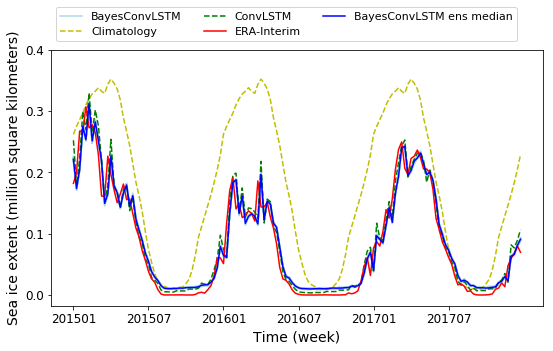

*******************  lead time 2  **********************


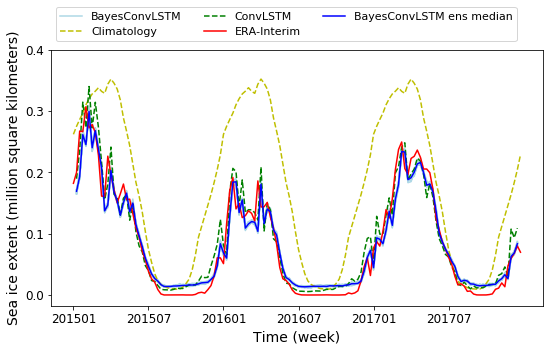

*******************  lead time 3  **********************


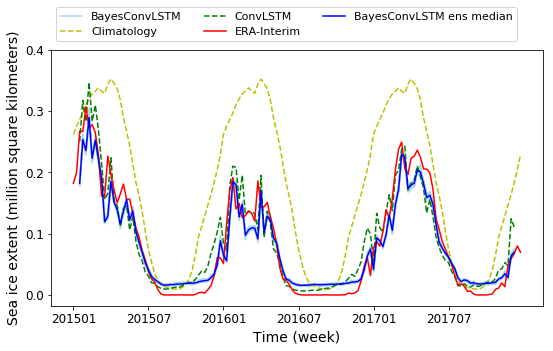

*******************  lead time 6  **********************


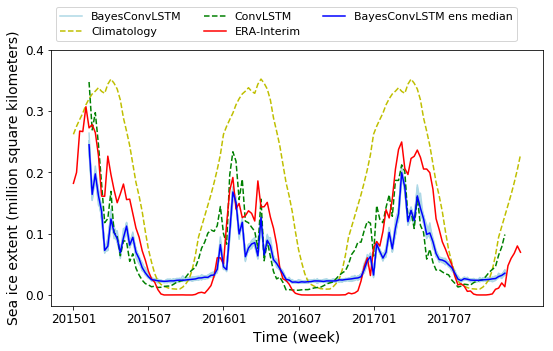

*******************  lead time 16  **********************


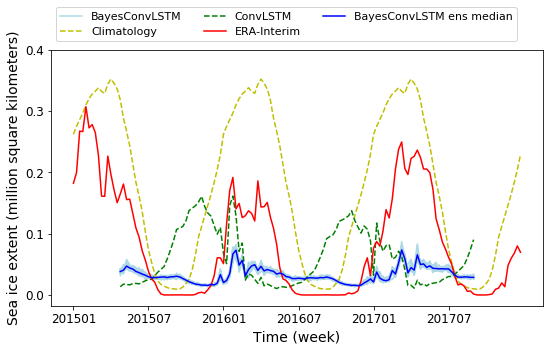

In [18]:
    #################################################################################
    ########   visualization of lead time dependent prediction - SIE area    ########
    #################################################################################
    index_plot = np.arange(test_year*12*4)
    index_plot_step = np.arange(test_year*12*4+1)
    year_index = np.arange(2015,2018,1)

    print ("*******************  Predicted Ice Extent  **********************")
    # include text box in the figure
    #text_content = '$RMSE=%.3f$ ' % (error_pred)
    predictand_sum = np.sum(np.sum(predictand,4),3)
    predictand_determin_sum = np.sum(np.sum(predictand_determin,3),2)
    print ("*******************  lead time 1  **********************")
    fig5 = plt.figure(figsize=(8,5))
    for i in range(ens):
        if i == 0:
            plt.plot(index_plot, predictand_sum[i,:,0]* sic_max / 1E+6,
                     color='lightblue', label="BayesConvLSTM")
        else:
            plt.plot(index_plot, predictand_sum[i,:,0]* sic_max / 1E+6, color='lightblue')
            
    plt.plot(index_plot, climatology_seq_sum * sic_max / 1E+6, 'y--', label="Climatology")
    plt.plot(index_plot, predictand_determin_sum[:,0] * sic_max / 1E+6, 'g--', label="ConvLSTM")
    plt.plot(index_plot, np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1)* sic_max / 1E+6, 'r', label="ERA-Interim")
    plt.plot(index_plot, np.median(predictand_sum[:,:,0],0)* sic_max / 1E+6, 'b', label="BayesConvLSTM ens median")
    plt.xlabel('Time (week)',fontsize = 14)
    plt.ylabel('Sea ice extent (million square kilometers)',fontsize = 14)
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201501', '201507', '201601', '201607',
                                                 '201701', '201707']),
               fontsize = 12)
    plt.yticks(np.arange(0,0.5,0.1), fontsize = 12)
    plt.legend(bbox_to_anchor=(0.01,1.10), loc="center left", borderaxespad=0, prop={'size': 11.0}, ncol=3)
    plt.tight_layout()
    plt.show()
    fig5.savefig(os.path.join(output_path,'sic_ERAI_bayesconvlstm_pred_extent_leadtime_1.png'),dpi=150)
    plt.close()    
    print ("*******************  lead time 2  **********************")
    fig6 = plt.figure(figsize=(8,5))
    for i in range(ens):
        if i == 0:
            plt.plot(index_plot[1:-1], predictand_sum[i,1:-1,1]* sic_max / 1E+6,
                     color='lightblue', label="BayesConvLSTM")
        else:
            plt.plot(index_plot[1:-1], predictand_sum[i,1:-1,1]* sic_max / 1E+6, color='lightblue')
    
    plt.plot(index_plot, climatology_seq_sum * sic_max / 1E+6, 'y--', label="Climatology")
    plt.plot(index_plot[1:-1], predictand_determin_sum[1:-1,1] * sic_max / 1E+6, 'g--', label="ConvLSTM")
    plt.plot(index_plot, np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1)* sic_max / 1E+6, 'r', label="ERA-Interim")
    plt.plot(index_plot[1:-1], np.median(predictand_sum[:,1:-1,1],0)* sic_max / 1E+6, 'b', label="BayesConvLSTM ens median")
    plt.xlabel('Time (week)',fontsize = 14)
    plt.ylabel('Sea ice extent (million square kilometers)',fontsize = 14)
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201501', '201507', '201601', '201607',
                                                 '201701', '201707']),
               fontsize = 12)
    plt.yticks(np.arange(0,0.5,0.1), fontsize = 12)
    plt.legend(bbox_to_anchor=(0.01,1.10), loc="center left", borderaxespad=0, prop={'size': 11.0}, ncol=3)
    plt.tight_layout()
    plt.show()
    fig6.savefig(os.path.join(output_path,'sic_ERAI_bayesconvlstm_pred_extent_leadtime_2.png'),dpi=150)
    plt.close()
    
    print ("*******************  lead time 3  **********************")
    fig7 = plt.figure(figsize=(8,5))
    for i in range(ens):
        if i == 0:
            plt.plot(index_plot[2:-2], predictand_sum[i,2:-2,2]* sic_max / 1E+6,
                     color='lightblue', label="BayesConvLSTM")
        else:
            plt.plot(index_plot[2:-2], predictand_sum[i,2:-2,2]* sic_max / 1E+6, color='lightblue')
            
    plt.plot(index_plot, climatology_seq_sum * sic_max / 1E+6, 'y--', label="Climatology")
    plt.plot(index_plot[2:-2], predictand_determin_sum[2:-2,2] * sic_max / 1E+6, 'g--', label="ConvLSTM")
    plt.plot(index_plot, np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1)* sic_max / 1E+6, 'r', label="ERA-Interim")
    plt.plot(index_plot[2:-2], np.median(predictand_sum[:,2:-2,2],0)* sic_max / 1E+6, 'b', label="BayesConvLSTM ens median")
    plt.xlabel('Time (week)',fontsize = 14)
    plt.ylabel('Sea ice extent (million square kilometers)',fontsize = 14)
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201501', '201507', '201601', '201607',
                                                 '201701', '201707']),
               fontsize = 12)
    plt.yticks(np.arange(0,0.5,0.1), fontsize = 12)
    plt.legend(bbox_to_anchor=(0.01,1.10), loc="center left", borderaxespad=0, prop={'size': 11.0}, ncol=3)
    plt.tight_layout()
    plt.show()
    fig7.savefig(os.path.join(output_path,'sic_ERAI_bayesconvlstm_pred_extent_leadtime_3.png'),dpi=150)
    plt.close()
    print ("*******************  lead time 6  **********************")
    fig8 = plt.figure(figsize=(8,5))
    for i in range(ens):
        if i == 0:
            plt.plot(index_plot[5:-5], predictand_sum[i,5:-5,5]* sic_max / 1E+6,
                     color='lightblue', label="BayesConvLSTM")
        else:
            plt.plot(index_plot[5:-5], predictand_sum[i,5:-5,5]* sic_max / 1E+6, color='lightblue')
    
    plt.plot(index_plot, climatology_seq_sum * sic_max / 1E+6, 'y--', label="Climatology")
    plt.plot(index_plot[5:-5], predictand_determin_sum[5:-5,5] * sic_max / 1E+6, 'g--', label="ConvLSTM")
    plt.plot(index_plot, np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1)* sic_max / 1E+6, 'r', label="ERA-Interim")
    plt.plot(index_plot[5:-5], np.median(predictand_sum[:,5:-5,5],0)* sic_max / 1E+6, 'b', label="BayesConvLSTM ens median")
    plt.xlabel('Time (week)',fontsize = 14)
    plt.ylabel('Sea ice extent (million square kilometers)',fontsize = 14)
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201501', '201507', '201601', '201607',
                                                 '201701', '201707']),
               fontsize = 12)
    plt.yticks(np.arange(0,0.5,0.1), fontsize = 12)
    plt.legend(bbox_to_anchor=(0.01,1.10), loc="center left", borderaxespad=0, prop={'size': 11.0}, ncol=3)
    plt.tight_layout()
    plt.show()
    fig8.savefig(os.path.join(output_path,'sic_ERAI_bayesconvlstm_pred_extent_leadtime_6.png'),dpi=150)
    plt.close()
    print ("*******************  lead time 16  **********************")
    
    fig7 = plt.figure(figsize=(8,5))
    for i in range(ens):
        if i == 0:
            plt.plot(index_plot[15:-15], predictand_sum[i,15:-15,15]* sic_max / 1E+6,
                     color='lightblue', label="BayesConvLSTM")
        else:
            plt.plot(index_plot[15:-15], predictand_sum[i,15:-15,15]* sic_max / 1E+6, color='lightblue')
            
    plt.plot(index_plot, climatology_seq_sum * sic_max / 1E+6, 'y--', label="Climatology")
    plt.plot(index_plot[15:-15], predictand_determin_sum[15:-15,15] * sic_max / 1E+6, 'g--', label="ConvLSTM")
    plt.plot(index_plot, np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1)* sic_max / 1E+6, 'r', label="ERA-Interim")
    plt.plot(index_plot[15:-15], np.median(predictand_sum[:,15:-15,15],0)* sic_max / 1E+6, 'b', label="BayesConvLSTM ens median")
    plt.xlabel('Time (week)',fontsize = 14)
    plt.ylabel('Sea ice extent (million square kilometers)',fontsize = 14)
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201501', '201507', '201601', '201607',
                                                 '201701', '201707']),
               fontsize = 12)
    plt.yticks(np.arange(0,0.5,0.1), fontsize = 12)
    plt.legend(bbox_to_anchor=(0.01,1.10), loc="center left", borderaxespad=0, prop={'size': 11.0}, ncol=3)
    plt.tight_layout()
    plt.show()
    fig7.savefig(os.path.join(output_path,'sic_ERAI_bayesconvlstm_pred_extent_leadtime_16.png'),dpi=150)
    plt.close()

*******************  Predicted Ice Extent  **********************


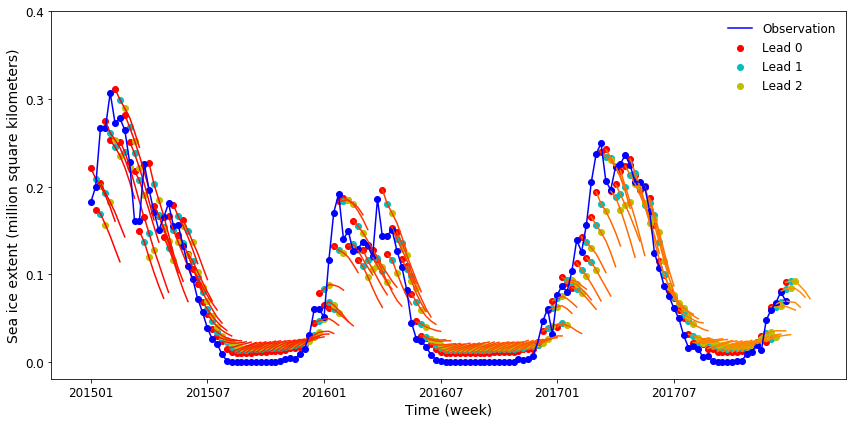

*******************  Prediction Ice Distribution  **********************
###   MAE for all months during testing period   ###
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


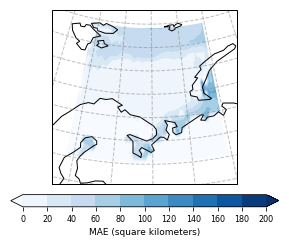

*******************  histrogram of the values **********************


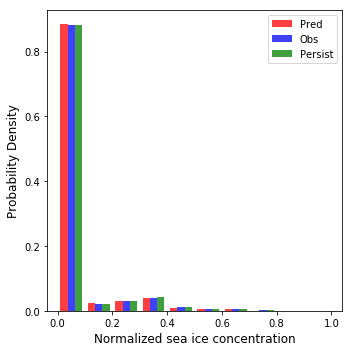

*******************  scatter obs data v.s. testing data **********************


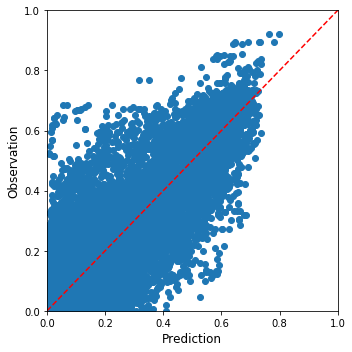

*******************  quantile mapping obs data v.s. testing data **********************


In [15]:
    #################################################################################
    ########  visualization of lead time dependent prediction - diagnostic   ########
    #################################################################################
    index_plot = np.arange(test_year*12*4)
    index_plot_step_1 = np.arange(test_year*12*4+1)
    index_plot_step_2 = np.arange(test_year*12*4+2)
    year_index = np.arange(2015,2018,1)
    
    print ("*******************  Predicted Ice Extent  **********************")
    # include text box in the figure
    #text_content = '$RMSE=%.3f$ ' % (error_pred)
    predictand_sum = np.sum(np.sum(predictand,4),3)
    # predict x steps ahead
    step_lead = 6 # unit week
    colormap=cm.autumn(range(test_year*12*4))
    
    fig0 = plt.figure(figsize=(12,6))
    for i in range(test_year*12*4):
        plt.plot(np.arange(index_plot[i],index_plot[i]+step_lead),
                 np.median(predictand_sum[:,i,:step_lead] * sic_max / 1E+6, 0), color=colormap[i])
    #plt.scatter(index_plot, predictand_determin_sum[:,0] * sic_max / 1E+6,
    #            color='g', label="Deterministic")
    plt.scatter(index_plot, np.median(predictand_sum[:,:,0] * sic_max / 1E+6, 0),
                color='r', label="Lead 0")
    plt.scatter(index_plot_step_1[1:], np.median(predictand_sum[:,:,1] * sic_max / 1E+6, 0),
                color='c', label="Lead 1")
    plt.scatter(index_plot_step_2[2:], np.median(predictand_sum[:,:,2] * sic_max / 1E+6, 0),
                color='y', label="Lead 2")
    plt.plot(index_plot, np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1)* sic_max/ 1E+6, 'b', label="Observation")
    plt.scatter(index_plot,np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1)* sic_max/ 1E+6, color='b')
    #plt.plot(index_plot, climatology, 'c--',label="climatology")
    plt.xlabel('Time (week)',fontsize = 14)
    plt.ylabel('Sea ice extent (million square kilometers)',fontsize = 14)
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201501', '201507', '201601', '201607',
                                                 '201701', '201707']),
               fontsize = 12)
    plt.yticks(np.arange(0,0.5,0.1), fontsize = 12)
    plt.legend(frameon=False, loc=1, prop={'size': 12})
    #props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    #ax = plt.gca()
    #ax.text(0.03,0.2,text_content,transform=ax.transAxes,fontsize=10,verticalalignment='top',bbox=props)
    plt.tight_layout()
    plt.show()
    fig0.savefig(os.path.join(output_path,'sic_ERAI_bayesconvlstm_pred_extent_leadtime.png'),dpi=150)    

    print ("*******************  Prediction Ice Distribution  **********************")
    mae = dlacs.metric.MAE(np.median(predictand[:,:,0,:,:],0), sic_exp_norm[-test_year*12*4:,:,:])
    print("###   MAE for all months during testing period   ###")
    label = 'MAE (square kilometers)'
    ticks = [i for i in np.linspace(0,200,11)]
    dlacs.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                mae * sic_max, label, ticks,
                                os.path.join(output_path,'spatial_sic_mae_avg_leadtime_1.png'),
                                boundary='Barents_Polar', colormap='Blues')

       
    print ("*******************  histrogram of the values **********************")
    fig3 = plt.figure(figsize=(5,5))
    # make the probability density sum to be 1
    weights_pred = np.ones_like(predictand_median[:,0,:,:].flatten())/float(len(predictand_median[:,0,:,:].flatten()))
    weights_obs = np.ones_like(sic_exp_norm[-test_year*12*4:,:,:].flatten())/float(len(sic_exp_norm[-test_year*12*4:,:,:].flatten()))
    weight_persist = np.ones_like(sic_exp_norm[-test_year*12*4-1:-1,:,:].flatten())/float(len(sic_exp_norm[-test_year*12*4-1:-1,:,:].flatten()))
    plt.hist(np.vstack((predictand_median[:,0,:,:].flatten(),
                        sic_exp_norm[-test_year*12*4:,:,:].flatten(),
                        sic_exp_norm[-test_year*12*4-1:-1,:,:].flatten())).T,
             bins=10, range=(0.0,1.0), weights=np.vstack((weights_pred,weights_obs,weight_persist)).T,
             density=False, color=['r','b','g'], alpha=0.75, label=['Pred','Obs','Persist'])
    plt.xlabel('Normalized sea ice concentration', fontsize = 12)
    plt.ylabel('Probability Density', fontsize = 12)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    axes = plt.gca()
    #axes.set_ylim(0,0.9)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig3.savefig(os.path.join(output_path,'sic_ERAI_bayesconvlstm_pred_extent_hist_leadtime_1.png'),dpi=150)
    
    print ("*******************  scatter obs data v.s. testing data **********************")
    fig4 = plt.figure(figsize=(5,5))
    plt.scatter(np.sort(predictand_median[:,0,:,:]), np.sort(sic_exp_norm[-test_year*12*4:,:,:]))
    plt.xlabel('Prediction', fontsize = 12)
    plt.ylabel('Observation', fontsize = 12)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    axes = plt.gca()
    axes.set_xlim(0,1.0)
    axes.set_ylim(0,1.0)
    axes.plot(axes.get_xlim(), axes.get_ylim(), ls="--", c="r")
    #plt.plot(np.arange(0,1.0,11),np.arange(0,1.0,11),'r')
    #plt.legend()
    plt.tight_layout()
    plt.show()
    fig4.savefig(os.path.join(output_path,'sic_ERAI_bayesconvlstm_pred_extent_scatter_leadtime_1.png'),dpi=150)
    
    print ("*******************  quantile mapping obs data v.s. testing data **********************")
    # Draw quantile-quantile plot
#     plt.figure(figsize=(5,5))
#     dlacs.visual.qqplot(np.sort(predictand_median[:,0,:,:]), np.sort(sic_exp_norm[-test_year*12*4:,:,:]),
#                         c='r', alpha=0.5, edgecolor='k')
#     plt.xlabel('Prediction', fontsize = 12)
#     plt.ylabel('Observation', fontsize = 12)
#     axes = plt.gca()
#     axes.set_xlim(0,1.0)
#     axes.set_ylim(0,1.0)
#     axes.plot(axes.get_xlim(), axes.get_ylim(), ls="--", c="b", alpha=0.5)
#     #plt.title('Quantile Mapping')
#     plt.savefig(os.path.join(output_path,'sic_ERAI_bayesconvlstm_pred_extent_quantile_leadtime_1.png'),dpi=150)
#     plt.show()
#     plt.close()    

In [26]:
    #################################################################################
    ########            Evaluation of ensemble median with RMSE              ########
    ########              RMSE over time, and sum over domain                ########
    #################################################################################
    sequence_len, height, width = sic_exp_norm.shape
    print('##############################################################')
    print('############   start prediction with climatology  ############')
    print('##############################################################')
    RMSE_climatology, RMSE_climatology_std  = dlacs.metric.RMSE(climatology_seq * sic_max,
                                                                sic_exp_norm[-test_year*12*4:,:,:] * sic_max)
    RMSE_climatology = np.mean(RMSE_climatology)
    RMSE_climatology_std = np.mean(RMSE_climatology_std)
    print('##############################################################')
    print('############   start prediction with persistence  ############')
    print('##############################################################')
    RMSE_persist_0, RMSE_persist_0_std = dlacs.metric.RMSE(sic_exp_norm[-test_year*12*4-1:-1,:,:] * sic_max,
                                                           sic_exp_norm[-test_year*12*4:,:,:] * sic_max)
    RMSE_persist_1, RMSE_persist_1_std = dlacs.metric.RMSE(sic_exp_norm[-test_year*12*4-1:-2,:,:] * sic_max,
                                                           sic_exp_norm[-test_year*12*4+1:,:,:] * sic_max)
    RMSE_persist_2, RMSE_persist_2_std = dlacs.metric.RMSE(sic_exp_norm[-test_year*12*4-1:-3,:,:] * sic_max,
                                                           sic_exp_norm[-test_year*12*4+2:,:,:] * sic_max)
    RMSE_persist_3, RMSE_persist_3_std = dlacs.metric.RMSE(sic_exp_norm[-test_year*12*4-1:-4,:,:] * sic_max,
                                                           sic_exp_norm[-test_year*12*4+3:,:,:] * sic_max)
    RMSE_persist_4, RMSE_persist_4_std = dlacs.metric.RMSE(sic_exp_norm[-test_year*12*4-1:-5,:,:] * sic_max,
                                                           sic_exp_norm[-test_year*12*4+4:,:,:] * sic_max)
    RMSE_persist_5, RMSE_persist_5_std = dlacs.metric.RMSE(sic_exp_norm[-test_year*12*4-1:-6,:,:] * sic_max,
                                                           sic_exp_norm[-test_year*12*4+5:,:,:] * sic_max)
    RMSE_persist_6, RMSE_persist_6_std = dlacs.metric.RMSE(sic_exp_norm[-test_year*12*4-1:-7,:,:] * sic_max,
                                                           sic_exp_norm[-test_year*12*4+6:,:,:] * sic_max)
    RMSE_persist_7, RMSE_persist_7_std = dlacs.metric.RMSE(sic_exp_norm[-test_year*12*4-1:-8,:,:] * sic_max,
                                                           sic_exp_norm[-test_year*12*4+7:,:,:] * sic_max)
    RMSE_persist_8, RMSE_persist_8_std = dlacs.metric.RMSE(sic_exp_norm[-test_year*12*4-1:-9,:,:] * sic_max,
                                                           sic_exp_norm[-test_year*12*4+8:,:,:] * sic_max)
    RMSE_persist_9, RMSE_persist_9_std = dlacs.metric.RMSE(sic_exp_norm[-test_year*12*4-1:-10,:,:] * sic_max,
                                                           sic_exp_norm[-test_year*12*4+9:,:,:] * sic_max)
    RMSE_persist_10, RMSE_persist_10_std = dlacs.metric.RMSE(sic_exp_norm[-test_year*12*4-1:-11,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+10:,:,:] * sic_max)
    RMSE_persist_11, RMSE_persist_11_std = dlacs.metric.RMSE(sic_exp_norm[-test_year*12*4-1:-12,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+11:,:,:] * sic_max)
    RMSE_persist_12, RMSE_persist_12_std = dlacs.metric.RMSE(sic_exp_norm[-test_year*12*4-1:-13,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+12:,:,:] * sic_max)
    RMSE_persist_13, RMSE_persist_13_std = dlacs.metric.RMSE(sic_exp_norm[-test_year*12*4-1:-14,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+13:,:,:] * sic_max)
    RMSE_persist_14, RMSE_persist_14_std = dlacs.metric.RMSE(sic_exp_norm[-test_year*12*4-1:-15,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+14:,:,:] * sic_max)
    RMSE_persist_15, RMSE_persist_15_std = dlacs.metric.RMSE(sic_exp_norm[-test_year*12*4-1:-16,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+15:,:,:] * sic_max)
    print('#################################################################################')
    print('############   evaluation and statistical matrix for the ConvLSTM    ############')
    print('#################################################################################')    
    RMSE_ConvLSTM_0, RMSE_ConvLSTM_0_std = dlacs.metric.RMSE(predictand_determin[:,0,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4:,:,:] * sic_max)
    RMSE_ConvLSTM_1, RMSE_ConvLSTM_1_std = dlacs.metric.RMSE(predictand_determin[:-1,1,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+1:,:,:] * sic_max)
    RMSE_ConvLSTM_2, RMSE_ConvLSTM_2_std = dlacs.metric.RMSE(predictand_determin[:-2,2,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+2:,:,:] * sic_max)
    RMSE_ConvLSTM_3, RMSE_ConvLSTM_3_std = dlacs.metric.RMSE(predictand_determin[:-3,3,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+3:,:,:] * sic_max)
    RMSE_ConvLSTM_4, RMSE_ConvLSTM_4_std = dlacs.metric.RMSE(predictand_determin[:-4,4,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+4:,:,:] * sic_max)
    RMSE_ConvLSTM_5, RMSE_ConvLSTM_5_std = dlacs.metric.RMSE(predictand_determin[:-5,5,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+5:,:,:] * sic_max)
    RMSE_ConvLSTM_6, RMSE_ConvLSTM_6_std = dlacs.metric.RMSE(predictand_determin[:-6,6,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+6:,:,:] * sic_max)
    RMSE_ConvLSTM_7, RMSE_ConvLSTM_7_std = dlacs.metric.RMSE(predictand_determin[:-7,7,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+7:,:,:] * sic_max)
    RMSE_ConvLSTM_8, RMSE_ConvLSTM_8_std = dlacs.metric.RMSE(predictand_determin[:-8,8,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+8:,:,:] * sic_max)
    RMSE_ConvLSTM_9, RMSE_ConvLSTM_9_std = dlacs.metric.RMSE(predictand_determin[:-9,9,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+9:,:,:] * sic_max)
    RMSE_ConvLSTM_10, RMSE_ConvLSTM_10_std = dlacs.metric.RMSE(predictand_determin[:-10,10,:,:] * sic_max,
                                                               sic_exp_norm[-test_year*12*4+10:,:,:] * sic_max)
    RMSE_ConvLSTM_11, RMSE_ConvLSTM_11_std = dlacs.metric.RMSE(predictand_determin[:-11,11,:,:] * sic_max,
                                                               sic_exp_norm[-test_year*12*4+11:,:,:] * sic_max)
    RMSE_ConvLSTM_12, RMSE_ConvLSTM_12_std = dlacs.metric.RMSE(predictand_determin[:-12,12,:,:] * sic_max,
                                                               sic_exp_norm[-test_year*12*4+12:,:,:] * sic_max)
    RMSE_ConvLSTM_13, RMSE_ConvLSTM_13_std = dlacs.metric.RMSE(predictand_determin[:-13,13,:,:] * sic_max,
                                                               sic_exp_norm[-test_year*12*4+13:,:,:] * sic_max)
    RMSE_ConvLSTM_14, RMSE_ConvLSTM_14_std = dlacs.metric.RMSE(predictand_determin[:-14,14,:,:] * sic_max,
                                                               sic_exp_norm[-test_year*12*4+14:,:,:] * sic_max)
    RMSE_ConvLSTM_15, RMSE_ConvLSTM_15_std = dlacs.metric.RMSE(predictand_determin[:-15,15,:,:] * sic_max,
                                                               sic_exp_norm[-test_year*12*4+15:,:,:] * sic_max)    
    
    print('#################################################################################')
    print('############   evaluation and statistical matrix for BayesConvLSTM   ############')
    print('#################################################################################')
    RMSE_BayesConvLSTM_0, RMSE_BayesConvLSTM_0_std = dlacs.metric.RMSE(predictand_median[:,0,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4:,:,:] * sic_max)
    RMSE_BayesConvLSTM_1, RMSE_BayesConvLSTM_1_std = dlacs.metric.RMSE(predictand_median[:-1,1,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+1:,:,:] * sic_max)
    RMSE_BayesConvLSTM_2, RMSE_BayesConvLSTM_2_std = dlacs.metric.RMSE(predictand_median[:-2,2,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+2:,:,:] * sic_max)
    RMSE_BayesConvLSTM_3, RMSE_BayesConvLSTM_3_std = dlacs.metric.RMSE(predictand_median[:-3,3,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+3:,:,:] * sic_max)
    RMSE_BayesConvLSTM_4, RMSE_BayesConvLSTM_4_std = dlacs.metric.RMSE(predictand_median[:-4,4,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+4:,:,:] * sic_max)
    RMSE_BayesConvLSTM_5, RMSE_BayesConvLSTM_5_std = dlacs.metric.RMSE(predictand_median[:-5,5,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+5:,:,:] * sic_max)
    RMSE_BayesConvLSTM_6, RMSE_BayesConvLSTM_6_std = dlacs.metric.RMSE(predictand_median[:-6,6,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+6:,:,:] * sic_max)
    RMSE_BayesConvLSTM_7, RMSE_BayesConvLSTM_7_std = dlacs.metric.RMSE(predictand_median[:-7,7,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+7:,:,:] * sic_max)
    RMSE_BayesConvLSTM_8, RMSE_BayesConvLSTM_8_std = dlacs.metric.RMSE(predictand_median[:-8,8,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+8:,:,:] * sic_max)
    RMSE_BayesConvLSTM_9, RMSE_BayesConvLSTM_9_std = dlacs.metric.RMSE(predictand_median[:-9,9,:,:] * sic_max,
                                                             sic_exp_norm[-test_year*12*4+9:,:,:] * sic_max)
    RMSE_BayesConvLSTM_10, RMSE_BayesConvLSTM_10_std = dlacs.metric.RMSE(predictand_median[:-10,10,:,:] * sic_max,
                                                               sic_exp_norm[-test_year*12*4+10:,:,:] * sic_max)
    RMSE_BayesConvLSTM_11, RMSE_BayesConvLSTM_11_std = dlacs.metric.RMSE(predictand_median[:-11,11,:,:] * sic_max,
                                                               sic_exp_norm[-test_year*12*4+11:,:,:] * sic_max)
    RMSE_BayesConvLSTM_12, RMSE_BayesConvLSTM_12_std = dlacs.metric.RMSE(predictand_median[:-12,12,:,:] * sic_max,
                                                               sic_exp_norm[-test_year*12*4+12:,:,:] * sic_max)
    RMSE_BayesConvLSTM_13, RMSE_BayesConvLSTM_13_std = dlacs.metric.RMSE(predictand_median[:-13,13,:,:] * sic_max,
                                                               sic_exp_norm[-test_year*12*4+13:,:,:] * sic_max)
    RMSE_BayesConvLSTM_14, RMSE_BayesConvLSTM_14_std = dlacs.metric.RMSE(predictand_median[:-14,14,:,:] * sic_max,
                                                               sic_exp_norm[-test_year*12*4+14:,:,:] * sic_max)
    RMSE_BayesConvLSTM_15, RMSE_BayesConvLSTM_15_std = dlacs.metric.RMSE(predictand_median[:-15,15,:,:] * sic_max,
                                                               sic_exp_norm[-test_year*12*4+15:,:,:] * sic_max)
    print("*******************     Lead time 0     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_0),"+-",np.mean(RMSE_ConvLSTM_0_std))
    print("Mean RMSE with testing data - Climatology")
    print(RMSE_climatology,"+-",RMSE_climatology_std)
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_0),"+-",np.mean(RMSE_persist_0_std))
    print("Mean RMSE with testing data - BayesConvLSTM")
    print(np.mean(RMSE_BayesConvLSTM_0),"+-",np.mean(RMSE_BayesConvLSTM_0_std))
    print("*******************     Lead time 1     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_1),"+-",np.mean(RMSE_ConvLSTM_1_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_1),"+-",np.mean(RMSE_persist_1_std))
    print("Mean RMSE with testing data - BayesConvLSTM")
    print(np.mean(RMSE_BayesConvLSTM_1),"+-",np.mean(RMSE_BayesConvLSTM_1_std))
    print("*******************     Lead time 2     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_2),"+-",np.mean(RMSE_ConvLSTM_2_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_2),"+-",np.mean(RMSE_persist_2_std))
    print("Mean RMSE with testing data - BayesConvLSTM")
    print(np.mean(RMSE_BayesConvLSTM_2),"+-",np.mean(RMSE_BayesConvLSTM_2_std))
    print("*******************     Lead time 3     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_3),"+-",np.mean(RMSE_ConvLSTM_3_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_3),"+-",np.mean(RMSE_persist_3_std))
    print("Mean RMSE with testing data - BayesConvLSTM")
    print(np.mean(RMSE_BayesConvLSTM_3),"+-",np.mean(RMSE_BayesConvLSTM_3_std))
    print("*******************     Lead time 4     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_4),"+-",np.mean(RMSE_ConvLSTM_4_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_4),"+-",np.mean(RMSE_persist_4_std))
    print("Mean RMSE with testing data - BayesConvLSTM")
    print(np.mean(RMSE_BayesConvLSTM_4),"+-",np.mean(RMSE_BayesConvLSTM_4_std))
    print("*******************     Lead time 5     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_5),"+-",np.mean(RMSE_ConvLSTM_5_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_5),"+-",np.mean(RMSE_persist_5_std))
    print("Mean RMSE with testing data - BayesConvLSTM")
    print(np.mean(RMSE_BayesConvLSTM_5),"+-",np.mean(RMSE_BayesConvLSTM_5_std))
    print("*******************     Lead time 6     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_6),"+-",np.mean(RMSE_ConvLSTM_6_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_6),"+-",np.mean(RMSE_persist_6_std))
    print("Mean RMSE with testing data - BayesConvLSTM")
    print(np.mean(RMSE_BayesConvLSTM_6),"+-",np.mean(RMSE_BayesConvLSTM_6_std))
    print("*******************     Lead time 7     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_7),"+-",np.mean(RMSE_ConvLSTM_7_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_7),"+-",np.mean(RMSE_persist_7_std))
    print("Mean RMSE with testing data - BayesConvLSTM")
    print(np.mean(RMSE_BayesConvLSTM_7),"+-",np.mean(RMSE_BayesConvLSTM_7_std))
    print("*******************     Lead time 8     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_8),"+-",np.mean(RMSE_ConvLSTM_8_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_8),"+-",np.mean(RMSE_persist_8_std))
    print("Mean RMSE with testing data - BayesConvLSTM")
    print(np.mean(RMSE_BayesConvLSTM_8),"+-",np.mean(RMSE_BayesConvLSTM_8_std))
    print("*******************     Lead time 9     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_9),"+-",np.mean(RMSE_ConvLSTM_9_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_9),"+-",np.mean(RMSE_persist_9_std))
    print("Mean RMSE with testing data - BayesConvLSTM")
    print(np.mean(RMSE_BayesConvLSTM_9),"+-",np.mean(RMSE_BayesConvLSTM_9_std))
    print("*******************     Lead time 10     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_10),"+-",np.mean(RMSE_ConvLSTM_10_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_10),"+-",np.mean(RMSE_persist_10_std))
    print("Mean RMSE with testing data - BayesConvLSTM")
    print(np.mean(RMSE_BayesConvLSTM_10),"+-",np.mean(RMSE_BayesConvLSTM_10_std))
    print("*******************     Lead time 11     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_11),"+-",np.mean(RMSE_ConvLSTM_11_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_11),"+-",np.mean(RMSE_persist_11_std))
    print("Mean RMSE with testing data - BayesConvLSTM")
    print(np.mean(RMSE_BayesConvLSTM_11),"+-",np.mean(RMSE_BayesConvLSTM_11_std))
    print("*******************     Lead time 12     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_12),"+-",np.mean(RMSE_ConvLSTM_12_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_12),"+-",np.mean(RMSE_persist_12_std))
    print("Mean RMSE with testing data - BayesConvLSTM")
    print(np.mean(RMSE_BayesConvLSTM_12),"+-",np.mean(RMSE_BayesConvLSTM_12_std))
    print("*******************     Lead time 13     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_13),"+-",np.mean(RMSE_ConvLSTM_13_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_13),"+-",np.mean(RMSE_persist_13_std))
    print("Mean RMSE with testing data - BayesConvLSTM")
    print(np.mean(RMSE_BayesConvLSTM_13),"+-",np.mean(RMSE_BayesConvLSTM_13_std))
    print("*******************     Lead time 14     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_14),"+-",np.mean(RMSE_ConvLSTM_14_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_14),"+-",np.mean(RMSE_persist_14_std))
    print("Mean RMSE with testing data - BayesConvLSTM")
    print(np.mean(RMSE_BayesConvLSTM_14),"+-",np.mean(RMSE_BayesConvLSTM_14_std))
    print("*******************     Lead time 15     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_15),"+-",np.mean(RMSE_ConvLSTM_15_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_15),"+-",np.mean(RMSE_persist_15_std))
    print("Mean RMSE with testing data - BayesConvLSTM")
    print(np.mean(RMSE_BayesConvLSTM_15),"+-",np.mean(RMSE_BayesConvLSTM_15_std))
    print('##############################################################')
    print('############           create a txt file          ############')
    print('##############################################################')
    f = open(os.path.join(output_path,"report_rmse_pred_16weeks.txt"),"w+")
    f.write("############   evaluation of prediction   ############\n")
    f.write("############   Total RMSE with testing data   ############\n")
    f.write("*******************     Lead time 0     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_0),np.mean(RMSE_ConvLSTM_0_std)))
    f.write("RMSE - Climatology    {} + - {}\n".format(RMSE_climatology, RMSE_climatology_std))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_0),np.mean(RMSE_persist_0_std)))
    f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(RMSE_BayesConvLSTM_0),np.mean(RMSE_BayesConvLSTM_0_std)))
    f.write("*******************     Lead time 1     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_1),np.mean(RMSE_ConvLSTM_1_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_1),np.mean(RMSE_persist_1_std)))
    f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(RMSE_BayesConvLSTM_1),np.mean(RMSE_BayesConvLSTM_1_std)))
    f.write("*******************     Lead time 2     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_2),np.mean(RMSE_ConvLSTM_2_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_2),np.mean(RMSE_persist_2_std)))
    f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(RMSE_BayesConvLSTM_2),np.mean(RMSE_BayesConvLSTM_2_std)))
    f.write("*******************     Lead time 3     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_3),np.mean(RMSE_ConvLSTM_3_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_3),np.mean(RMSE_persist_3_std)))
    f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(RMSE_BayesConvLSTM_3),np.mean(RMSE_BayesConvLSTM_3_std)))
    f.write("*******************     Lead time 4     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_4),np.mean(RMSE_ConvLSTM_4_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_4),np.mean(RMSE_persist_4_std)))
    f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(RMSE_BayesConvLSTM_4),np.mean(RMSE_BayesConvLSTM_4_std)))
    f.write("*******************     Lead time 5     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_5),np.mean(RMSE_ConvLSTM_5_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_5),np.mean(RMSE_persist_5_std)))
    f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(RMSE_BayesConvLSTM_5),np.mean(RMSE_BayesConvLSTM_5_std)))
    f.write("*******************     Lead time 6     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_6),np.mean(RMSE_ConvLSTM_6_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_6),np.mean(RMSE_persist_6_std)))
    f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(RMSE_BayesConvLSTM_6),np.mean(RMSE_BayesConvLSTM_6_std)))
    f.write("*******************     Lead time 7     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_7),np.mean(RMSE_ConvLSTM_7_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_7),np.mean(RMSE_persist_7_std)))
    f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(RMSE_BayesConvLSTM_7),np.mean(RMSE_BayesConvLSTM_7_std)))
    f.write("*******************     Lead time 8     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_8),np.mean(RMSE_ConvLSTM_8_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_8),np.mean(RMSE_persist_8_std)))
    f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(RMSE_BayesConvLSTM_8),np.mean(RMSE_BayesConvLSTM_8_std)))
    f.write("*******************     Lead time 9     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_9),np.mean(RMSE_ConvLSTM_9_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_9),np.mean(RMSE_persist_9_std)))
    f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(RMSE_BayesConvLSTM_9),np.mean(RMSE_BayesConvLSTM_9_std)))
    f.write("*******************     Lead time 10     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_10),np.mean(RMSE_ConvLSTM_10_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_10),np.mean(RMSE_persist_10_std)))
    f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(RMSE_BayesConvLSTM_10),np.mean(RMSE_BayesConvLSTM_10_std)))
    f.write("*******************     Lead time 11     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_11),np.mean(RMSE_ConvLSTM_11_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_11),np.mean(RMSE_persist_11_std)))
    f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(RMSE_BayesConvLSTM_11),np.mean(RMSE_BayesConvLSTM_11_std)))
    f.write("*******************     Lead time 12     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_12),np.mean(RMSE_ConvLSTM_12_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_12),np.mean(RMSE_persist_12_std)))
    f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(RMSE_BayesConvLSTM_12),np.mean(RMSE_BayesConvLSTM_12_std)))
    f.write("*******************     Lead time 13     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_13),np.mean(RMSE_ConvLSTM_13_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_13),np.mean(RMSE_persist_13_std)))
    f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(RMSE_BayesConvLSTM_13),np.mean(RMSE_BayesConvLSTM_13_std)))
    f.write("*******************     Lead time 14     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_14),np.mean(RMSE_ConvLSTM_14_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_14),np.mean(RMSE_persist_14_std)))
    f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(RMSE_BayesConvLSTM_14),np.mean(RMSE_BayesConvLSTM_14_std)))
    f.write("*******************     Lead time 15     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_15),np.mean(RMSE_ConvLSTM_15_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_15),np.mean(RMSE_persist_15_std)))
    f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(RMSE_BayesConvLSTM_15),np.mean(RMSE_BayesConvLSTM_15_std)))
    f.write("-\n")
    f.write("-\n")
    f.write("-\n")
    f.write("############   Monthly RMSE with testing data   ############\n")
    f.write("*******************     Lead time 0     *******************\n")
    for i in np.arange(1,13,1):
        ConvLSTM_monthly_series = dlacs.preprocess.week2month(predictand_determin[:,0,:,:], i)
        persist_monthly_series = dlacs.preprocess.week2month(sic_exp_norm[-test_year*12*4-1:-1,:,:], i)
        climatology_monthly_series = dlacs.preprocess.week2month(climatology_seq, i)
        BayesConvLSTM_monthly_series = dlacs.preprocess.week2month(predictand_median[:,0,:,:], i)
        truth_monthly_series = dlacs.preprocess.week2month(sic_exp_norm[-test_year*12*4:,:,:], i)
        
        rmse_ConvLSTM_monthly, rmse_ConvLSTM_monthly_std = dlacs.metric.RMSE(ConvLSTM_monthly_series * sic_max,truth_monthly_series * sic_max)
        rmse_persist_monthly, rmse_persist_monthly_std = dlacs.metric.RMSE(persist_monthly_series * sic_max,truth_monthly_series * sic_max)
        rmse_climatology_monthly, rmse_climatology_monthly_std = dlacs.metric.RMSE(climatology_monthly_series * sic_max,truth_monthly_series * sic_max)
        rmse_BayesConvLSTM_monthly, rmse_BayesConvLSTM_monthly_std = dlacs.metric.RMSE(BayesConvLSTM_monthly_series * sic_max,truth_monthly_series * sic_max)
        
        print("*******************    {}     *******************".format(i))
        print("RMSE - ConvLSTM       {} + - {}".format(np.mean(rmse_ConvLSTM_monthly), np.mean(rmse_ConvLSTM_monthly_std)))
        print("RMSE - Climatology    {} + - {}".format(np.mean(rmse_climatology_monthly), np.mean(rmse_climatology_monthly_std)))
        print("RMSE - Persistence    {} + - {}".format(np.mean(rmse_persist_monthly), np.mean(rmse_persist_monthly_std)))
        print("RMSE - BayesConvLSTM  {} + - {}".format(np.mean(rmse_BayesConvLSTM_monthly), np.mean(rmse_BayesConvLSTM_monthly_std)))
        f.write("*******************    {}     *******************\n".format(i))
        f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(rmse_ConvLSTM_monthly), np.mean(rmse_ConvLSTM_monthly_std)))
        f.write("RMSE - Climatology    {} + - {}\n".format(np.mean(rmse_climatology_monthly), np.mean(rmse_climatology_monthly_std)))
        f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(rmse_persist_monthly), np.mean(rmse_persist_monthly_std)))
        f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(rmse_BayesConvLSTM_monthly), np.mean(rmse_BayesConvLSTM_monthly_std)))
    f.write("-\n")
    f.write("-\n")
    f.write("*******************     Lead time 1     *******************\n")
    print("*******************     Lead time 1     *******************")
    for i in np.arange(1,13,1):
        # the lead week makes the series shift and therefore not suitable for week2month
        # we fill the hole with 0
        ConvLSTM_without_hole = np.zeros(predictand_determin[:,0,:,:].shape, dtype=float)
        persist_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        BayesConvLSTM_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        truth_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        
        ConvLSTM_without_hole[1:,:,:] = predictand_determin[:-1,1,:,:]
        persist_without_hole[1:,:,:] = sic_exp_norm[-test_year*12*4-1:-2,:,:]
        BayesConvLSTM_without_hole[1:,:,:] = predictand_median[:-1,1,:,:]
        truth_without_hole[1:,:,:] = sic_exp_norm[-test_year*12*4+1:,:,:]
        
        ConvLSTM_monthly_series = dlacs.preprocess.week2month(ConvLSTM_without_hole, i)
        persist_monthly_series = dlacs.preprocess.week2month(persist_without_hole, i)
        BayesConvLSTM_monthly_series = dlacs.preprocess.week2month(BayesConvLSTM_without_hole, i)
        truth_monthly_series = dlacs.preprocess.week2month(truth_without_hole, i)
        
        rmse_ConvLSTM_monthly, rmse_ConvLSTM_monthly_std = dlacs.metric.RMSE(ConvLSTM_monthly_series * sic_max,truth_monthly_series * sic_max)
        rmse_persist_monthly, rmse_persist_monthly_std = dlacs.metric.RMSE(persist_monthly_series * sic_max,truth_monthly_series * sic_max)
        rmse_BayesConvLSTM_monthly, rmse_BayesConvLSTM_monthly_std = dlacs.metric.RMSE(BayesConvLSTM_monthly_series * sic_max,truth_monthly_series * sic_max)
        
        print("*******************    {}     *******************".format(i))
        print("RMSE - ConvLSTM       {} + - {}".format(np.mean(rmse_ConvLSTM_monthly), np.mean(rmse_ConvLSTM_monthly_std)))
        print("RMSE - Persistence    {} + - {}".format(np.mean(rmse_persist_monthly), np.mean(rmse_persist_monthly_std)))
        print("RMSE - BayesConvLSTM  {} + - {}".format(np.mean(rmse_BayesConvLSTM_monthly), np.mean(rmse_BayesConvLSTM_monthly_std)))
        f.write("*******************    {}     *******************\n".format(i))
        f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(rmse_ConvLSTM_monthly), np.mean(rmse_ConvLSTM_monthly_std)))
        f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(rmse_persist_monthly), np.mean(rmse_persist_monthly_std)))
        f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(rmse_BayesConvLSTM_monthly), np.mean(rmse_BayesConvLSTM_monthly_std)))
    f.write("-\n")
    f.write("-\n")        
    f.write("*******************     Lead time 2     *******************\n")
    print("*******************     Lead time 2     *******************")
    for i in np.arange(1,13,1):
        # the lead week makes the series shift and therefore not suitable for week2month
        # we fill the hole with 0
        ConvLSTM_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        persist_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        BayesConvLSTM_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        truth_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        
        ConvLSTM_without_hole[2:,:,:] = predictand_median[:-2,2,:,:]
        persist_without_hole[2:,:,:] = sic_exp_norm[-test_year*12*4-1:-3,:,:]
        BayesConvLSTM_without_hole[2:,:,:] = predictand_median[:-2,2,:,:]
        truth_without_hole[2:,:,:] = sic_exp_norm[-test_year*12*4+2:,:,:]
        
        ConvLSTM_monthly_series = dlacs.preprocess.week2month(ConvLSTM_without_hole, i)
        persist_monthly_series = dlacs.preprocess.week2month(persist_without_hole, i)
        BayesConvLSTM_monthly_series = dlacs.preprocess.week2month(BayesConvLSTM_without_hole, i)
        truth_monthly_series = dlacs.preprocess.week2month(truth_without_hole, i)
        
        rmse_ConvLSTM_monthly, rmse_ConvLSTM_monthly_std = dlacs.metric.RMSE(ConvLSTM_monthly_series * sic_max,truth_monthly_series * sic_max)
        rmse_persist_monthly, rmse_persist_monthly_std = dlacs.metric.RMSE(persist_monthly_series * sic_max,truth_monthly_series * sic_max)
        rmse_BayesConvLSTM_monthly, rmse_BayesConvLSTM_monthly_std = dlacs.metric.RMSE(BayesConvLSTM_monthly_series * sic_max,truth_monthly_series * sic_max)
        
        print("*******************    {}     *******************".format(i))
        print("RMSE - ConvLSTM       {} + - {}".format(np.mean(rmse_ConvLSTM_monthly), np.mean(rmse_ConvLSTM_monthly_std)))
        print("RMSE - Persistence    {} + - {}".format(np.mean(rmse_persist_monthly), np.mean(rmse_persist_monthly_std)))
        print("RMSE - BayesConvLSTM  {} + - {}".format(np.mean(rmse_BayesConvLSTM_monthly), np.mean(rmse_BayesConvLSTM_monthly_std)))
        f.write("*******************    {}     *******************\n".format(i))
        f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(rmse_ConvLSTM_monthly), np.mean(rmse_ConvLSTM_monthly_std)))
        f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(rmse_persist_monthly), np.mean(rmse_persist_monthly_std)))
        f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(rmse_BayesConvLSTM_monthly), np.mean(rmse_BayesConvLSTM_monthly_std)))
    f.write("-\n")
    f.write("-\n")
    f.write("*******************     Lead time 3     *******************\n")
    print("*******************     Lead time 3     *******************")
    for i in np.arange(1,13,1):
        # the lead week makes the series shift and therefore not suitable for week2month
        # we fill the hole with 0
        ConvLSTM_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        persist_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        BayesConvLSTM_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        truth_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        
        ConvLSTM_without_hole[3:,:,:] = predictand_median[:-3,3,:,:]
        persist_without_hole[3:,:,:] = sic_exp_norm[-test_year*12*4-1:-4,:,:]
        BayesConvLSTM_without_hole[3:,:,:] = predictand_median[:-3,3,:,:]
        truth_without_hole[3:,:,:] = sic_exp_norm[-test_year*12*4+3:,:,:]
        
        ConvLSTM_monthly_series = dlacs.preprocess.week2month(ConvLSTM_without_hole, i)
        persist_monthly_series = dlacs.preprocess.week2month(persist_without_hole, i)
        BayesConvLSTM_monthly_series = dlacs.preprocess.week2month(BayesConvLSTM_without_hole, i)
        truth_monthly_series = dlacs.preprocess.week2month(truth_without_hole, i)        
        
        rmse_ConvLSTM_monthly, rmse_ConvLSTM_monthly_std = dlacs.metric.RMSE(ConvLSTM_monthly_series * sic_max,truth_monthly_series * sic_max)
        rmse_persist_monthly, rmse_persist_monthly_std = dlacs.metric.RMSE(persist_monthly_series * sic_max,truth_monthly_series * sic_max)
        rmse_BayesConvLSTM_monthly, rmse_BayesConvLSTM_monthly_std = dlacs.metric.RMSE(BayesConvLSTM_monthly_series * sic_max,truth_monthly_series * sic_max)
        
        print("*******************    {}     *******************".format(i))
        print("RMSE - ConvLSTM       {} + - {}".format(np.mean(rmse_ConvLSTM_monthly), np.mean(rmse_ConvLSTM_monthly_std)))
        print("RMSE - Persistence    {} + - {}".format(np.mean(rmse_persist_monthly), np.mean(rmse_persist_monthly_std)))
        print("RMSE - BayesConvLSTM  {} + - {}".format(np.mean(rmse_BayesConvLSTM_monthly), np.mean(rmse_BayesConvLSTM_monthly_std)))
        f.write("*******************    {}     *******************\n".format(i))
        f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(rmse_ConvLSTM_monthly), np.mean(rmse_ConvLSTM_monthly_std)))
        f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(rmse_persist_monthly), np.mean(rmse_persist_monthly_std)))
        f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(rmse_BayesConvLSTM_monthly), np.mean(rmse_BayesConvLSTM_monthly_std)))
    f.write("-\n")
    f.write("-\n")
    f.write("*******************     Lead time 4     *******************\n")
    print("*******************     Lead time 4     *******************")
    for i in np.arange(1,13,1):
        # the lead week makes the series shift and therefore not suitable for week2month
        # we fill the hole with 0
        ConvLSTM_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        persist_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        BayesConvLSTM_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        truth_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        
        ConvLSTM_without_hole[4:,:,:] = predictand_median[:-4,4,:,:]
        persist_without_hole[4:,:,:] = sic_exp_norm[-test_year*12*4-1:-5,:,:]
        BayesConvLSTM_without_hole[4:,:,:] = predictand_median[:-4,4,:,:]
        truth_without_hole[4:,:,:] = sic_exp_norm[-test_year*12*4+4:,:,:]
        
        ConvLSTM_monthly_series = dlacs.preprocess.week2month(ConvLSTM_without_hole, i)
        persist_monthly_series = dlacs.preprocess.week2month(persist_without_hole, i)
        BayesConvLSTM_monthly_series = dlacs.preprocess.week2month(BayesConvLSTM_without_hole, i)
        truth_monthly_series = dlacs.preprocess.week2month(truth_without_hole, i)
        
        rmse_ConvLSTM_monthly, rmse_ConvLSTM_monthly_std = dlacs.metric.RMSE(ConvLSTM_monthly_series * sic_max,truth_monthly_series * sic_max)
        rmse_persist_monthly, rmse_persist_monthly_std = dlacs.metric.RMSE(persist_monthly_series * sic_max,truth_monthly_series * sic_max)
        rmse_BayesConvLSTM_monthly, rmse_BayesConvLSTM_monthly_std = dlacs.metric.RMSE(BayesConvLSTM_monthly_series * sic_max,truth_monthly_series * sic_max)
        
        print("*******************    {}     *******************".format(i))
        print("RMSE - ConvLSTM       {} + - {}".format(np.mean(rmse_ConvLSTM_monthly), np.mean(rmse_ConvLSTM_monthly_std)))
        print("RMSE - Persistence    {} + - {}".format(np.mean(rmse_persist_monthly), np.mean(rmse_persist_monthly_std)))
        print("RMSE - BayesConvLSTM  {} + - {}".format(np.mean(rmse_BayesConvLSTM_monthly), np.mean(rmse_BayesConvLSTM_monthly_std)))
        f.write("*******************    {}     *******************\n".format(i))
        f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(rmse_ConvLSTM_monthly), np.mean(rmse_ConvLSTM_monthly_std)))
        f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(rmse_persist_monthly), np.mean(rmse_persist_monthly_std)))
        f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(rmse_BayesConvLSTM_monthly), np.mean(rmse_BayesConvLSTM_monthly_std)))
    f.write("-\n")
    f.write("-\n")
    f.write("*******************     Lead time 5     *******************\n")
    print("*******************     Lead time 5     *******************")
    for i in np.arange(1,13,1):
        # the lead week makes the series shift and therefore not suitable for week2month
        # we fill the hole with 0
        ConvLSTM_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        persist_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        BayesConvLSTM_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        truth_without_hole = np.zeros(predictand_median[:,0,:,:].shape, dtype=float)
        
        ConvLSTM_without_hole[5:,:,:] = predictand_median[:-5,5,:,:]
        persist_without_hole[5:,:,:] = sic_exp_norm[-test_year*12*4-1:-6,:,:]
        BayesConvLSTM_without_hole[5:,:,:] = predictand_median[:-5,5,:,:]
        truth_without_hole[5:,:,:] = sic_exp_norm[-test_year*12*4+5:,:,:]
        
        ConvLSTM_monthly_series = dlacs.preprocess.week2month(ConvLSTM_without_hole, i)
        persist_monthly_series = dlacs.preprocess.week2month(persist_without_hole, i)
        BayesConvLSTM_monthly_series = dlacs.preprocess.week2month(BayesConvLSTM_without_hole, i)
        truth_monthly_series = dlacs.preprocess.week2month(truth_without_hole, i)              
        
        rmse_ConvLSTM_monthly, rmse_ConvLSTM_monthly_std = dlacs.metric.RMSE(ConvLSTM_monthly_series * sic_max,truth_monthly_series * sic_max)
        rmse_persist_monthly, rmse_persist_monthly_std = dlacs.metric.RMSE(persist_monthly_series * sic_max,truth_monthly_series * sic_max)
        rmse_BayesConvLSTM_monthly, rmse_BayesConvLSTM_monthly_std = dlacs.metric.RMSE(BayesConvLSTM_monthly_series * sic_max,truth_monthly_series * sic_max)
        
        print("*******************    {}     *******************".format(i))
        print("RMSE - ConvLSTM       {} + - {}".format(np.mean(rmse_ConvLSTM_monthly), np.mean(rmse_ConvLSTM_monthly_std)))
        print("RMSE - Persistence    {} + - {}".format(np.mean(rmse_persist_monthly), np.mean(rmse_persist_monthly_std)))
        print("RMSE - BayesConvLSTM  {} + - {}".format(np.mean(rmse_BayesConvLSTM_monthly), np.mean(rmse_BayesConvLSTM_monthly_std)))
        f.write("*******************    {}     *******************\n".format(i))
        f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(rmse_ConvLSTM_monthly), np.mean(rmse_ConvLSTM_monthly_std)))
        f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(rmse_persist_monthly), np.mean(rmse_persist_monthly_std)))
        f.write("RMSE - BayesConvLSTM  {} + - {}\n".format(np.mean(rmse_BayesConvLSTM_monthly), np.mean(rmse_BayesConvLSTM_monthly_std)))
    f.close()

##############################################################
############   start prediction with climatology  ############
##############################################################
##############################################################
############   start prediction with persistence  ############
##############################################################
#################################################################################
############   evaluation and statistical matrix for the ConvLSTM    ############
#################################################################################
#################################################################################
############   evaluation and statistical matrix for BayesConvLSTM   ############
#################################################################################
*******************     Lead time 0     *******************
Mean RMSE with testing data - ConvLSTM
49.916520820559654 +- 101.07788

In [20]:
    #################################################################################
    ########          transfer the sea ice fields into binary data           ########
    #################################################################################
    # ice concentration below the threshold is regarded as no ice, the value is from
    # https://nsidc.org/cryosphere/seaice/data/terminology.html
    criterion_0 = 0.15
    # remove the area weight
    sic_exp_denorm = np.zeros(sic_exp_norm.shape, dtype=float)
    lead_pred_sic_denorm = np.zeros(predictand.shape, dtype=float)
    for i in np.arange(height):
        lead_pred_sic_denorm[:,:,:,i,:] = predictand[:,:,:,i,:] /dx[i+12] * dx[35]
        sic_exp_denorm[:,i,:] = sic_exp_norm[:,i,:] / dx[i+12] * dx[35]
    # turn sea ice fields into binary data
    lead_pred_sic_bin = lead_pred_sic_denorm[:]
    sic_exp_bin = sic_exp_denorm[:]
    lead_pred_sic_bin[lead_pred_sic_bin <= criterion_0] = 0
    lead_pred_sic_bin[lead_pred_sic_bin > criterion_0] = 1
    sic_exp_bin[sic_exp_bin <= criterion_0] = 0
    sic_exp_bin[sic_exp_bin > criterion_0] = 1
    # turn matrix into int
    lead_pred_sic_bin = lead_pred_sic_bin.astype(int)
    sic_exp_bin = sic_exp_bin.astype(int)

year 2015 month 3 week 1
*******************  observation  **********************
###   Map of sea ice presence within observation   ###
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


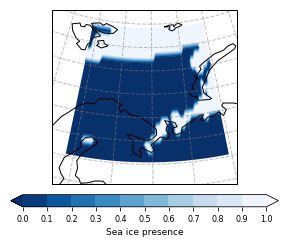

*******************  lead time 1  **********************
###   Probability map of sea ice presence by BayesConvLSTM   ###
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


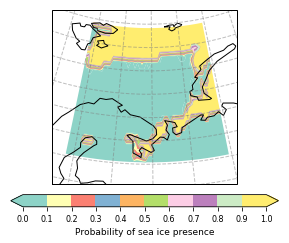

###   Uncertainty Map of sea ice presence by BayesConvLSTM   ###


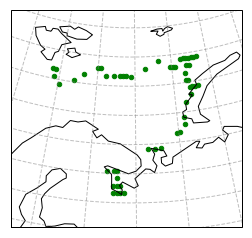

*******************  lead time 2  **********************
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


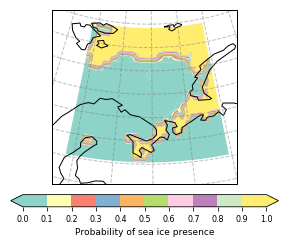

###   Uncertainty Map of sea ice presence by BayesConvLSTM   ###


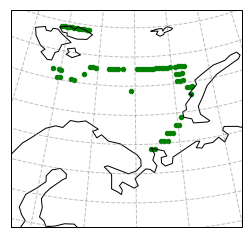

*******************  lead time 4  **********************
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


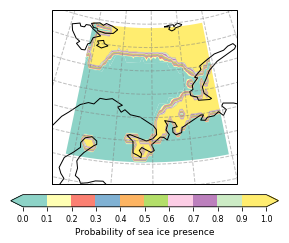

###   Uncertainty Map of sea ice presence by BayesConvLSTM   ###


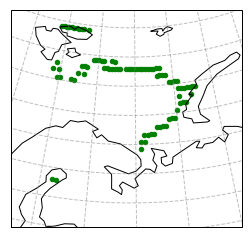

*******************  lead time 6  **********************
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


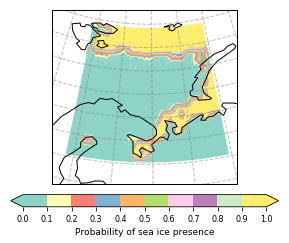

###   Uncertainty Map of sea ice presence by BayesConvLSTM   ###


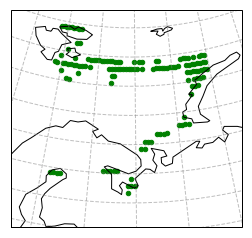

In [21]:
    #################################################################################
    ########        visualization of probabilistic sea ice prediction        ########
    #################################################################################
    index_plot = np.arange(test_year*12*3)
    index_plot_step = np.arange(test_year*12*4+1)
    year_index = np.arange(2015,2017,1)
    
    # starting from 0
    pred_time = 8
    year_name = np.repeat(year_index,48)
    month_cycle = np.repeat(np.arange(1,13,1),3)
    month_name = np.tile(month_cycle,3)
    week_name = np.tile(np.arange(1,5,1),48)
    print("year", year_name[pred_time], "month", month_name[pred_time],"week", week_name[pred_time])
    
    ice_prob_lead_1 = np.mean(lead_pred_sic_bin[:,pred_time,0,:,:],0)
    ice_prob_lead_2 = np.mean(lead_pred_sic_bin[:,pred_time-1,1,:,:],0)
    ice_prob_lead_4 = np.mean(lead_pred_sic_bin[:,pred_time-3,3,:,:],0)
    ice_prob_lead_6 = np.mean(lead_pred_sic_bin[:,pred_time-5,5,:,:],0)
    
    print ("*******************  observation  **********************")
    print("###   Map of sea ice presence within observation   ###")
    label = 'Sea ice presence'
    ticks = [i for i in np.linspace(0.0,1.0,11)]
    dlacs.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                sic_exp_bin[-test_year*12*4 + pred_time,:,:], label, ticks,
                                os.path.join(output_path,
                                'spatial_sic_obs_bin_{}_{}_{}.png'.format(year_name[pred_time], month_name[pred_time], week_name[pred_time])),
                                boundary='Barents_Polar',
                                colormap='Blues_r')    
    
    print ("*******************  lead time 1  **********************")
    print("###   Probability map of sea ice presence by BayesConvLSTM   ###")
    label = 'Probability of sea ice presence'
    ticks = [i for i in np.linspace(0.0,1.0,11)]
    #ticks = [0, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.7, 1.0]
    dlacs.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                ice_prob_lead_1, label, ticks,
                                os.path.join(output_path,
                                'spatial_sic_probability_pred_bin_{}_{}_{}_lead_1.png'.format(year_name[pred_time], month_name[pred_time], week_name[pred_time])),
                                boundary='Barents_Polar',
                                colormap='Set3')
    
    print("###   Uncertainty Map of sea ice presence by BayesConvLSTM   ###")
    jj, ii = np.where(np.logical_and(ice_prob_lead_1>=0.001, ice_prob_lead_1<=0.999))
    dlacs.visual.plots.location(lat_cut[jj], lon_cut[ii], 
                                os.path.join(output_path,
                                'map_pin_{}_{}_{}_lead_1.png'.format(year_name[pred_time], month_name[pred_time], week_name[pred_time])),
                                boundary='barents_polar')
    
    print ("*******************  lead time 2  **********************")
    ticks = [i for i in np.linspace(0.0,1.0,11)]
    #ticks = [0, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.7, 1.0]
    dlacs.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                ice_prob_lead_2, label, ticks,
                                os.path.join(output_path,
                                'spatial_sic_probability_pred_bin_{}_{}_{}_lead_2.png'.format(year_name[pred_time], month_name[pred_time], week_name[pred_time])),
                                boundary='Barents_Polar',
                                colormap='Set3')
    
    print("###   Uncertainty Map of sea ice presence by BayesConvLSTM   ###")
    jj, ii = np.where(np.logical_and(ice_prob_lead_2>=0.001, ice_prob_lead_2<=0.999))
    dlacs.visual.plots.location(lat_cut[jj], lon_cut[ii], 
                                os.path.join(output_path,
                                'map_pin_{}_{}_{}_lead_2.png'.format(year_name[pred_time], month_name[pred_time], week_name[pred_time])),
                                boundary='barents_polar')
    
    print ("*******************  lead time 4  **********************")
    ticks = [i for i in np.linspace(0.0,1.0,11)]
    #ticks = [0, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.7, 1.0]
    dlacs.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                ice_prob_lead_4, label, ticks,
                                os.path.join(output_path,
                                'spatial_sic_probability_pred_bin_{}_{}_{}_lead_4.png'.format(year_name[pred_time], month_name[pred_time], week_name[pred_time])),
                                boundary='Barents_Polar',
                                colormap='Set3')
    
    print("###   Uncertainty Map of sea ice presence by BayesConvLSTM   ###")
    jj, ii = np.where(np.logical_and(ice_prob_lead_4>=0.001, ice_prob_lead_4<=0.999))
    dlacs.visual.plots.location(lat_cut[jj], lon_cut[ii], 
                                os.path.join(output_path,
                                'map_pin_{}_{}_{}_lead_4.png'.format(year_name[pred_time], month_name[pred_time], week_name[pred_time])),
                                boundary='barents_polar')
    
    print ("*******************  lead time 6  **********************")
    ticks = [i for i in np.linspace(0.0,1.0,11)]
    #ticks = [0, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.7, 1.0]
    dlacs.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                ice_prob_lead_6, label, ticks,
                                os.path.join(output_path,
                                'spatial_sic_probability_pred_bin_{}_{}_{}_lead_6.png'.format(year_name[pred_time], month_name[pred_time], week_name[pred_time])),
                                boundary='Barents_Polar',
                                colormap='Set3')
    
    print("###   Uncertainty Map of sea ice presence by BayesConvLSTM   ###")
    jj, ii = np.where(np.logical_and(ice_prob_lead_6>=0.001, ice_prob_lead_6<=0.999))
    dlacs.visual.plots.location(lat_cut[jj], lon_cut[ii], 
                                os.path.join(output_path,
                                'map_pin_{}_{}_{}_lead_6.png'.format(year_name[pred_time], month_name[pred_time], week_name[pred_time])),
                                boundary='barents_polar')

In [35]:
    ##############################################################################################################
    ###########       Compute CRPS with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    step_lead = 16
    # data shape [ens, time, leadweek, lat, lon]
    # lead time dependent CRPS
    crps = np.zeros((step_lead), dtype=float)
    #crps_unit = np.zeros((test_year*12*4,step_lead,len(lat_cut),len(lon_cut)), dtype=float)
    for i in range(step_lead):
        if i == 0:
            _, crps[i] = dlacs.metric.CRPS(sic_exp_denorm[-test_year*12*4+i:,:,:],
                                           lead_pred_sic_denorm[:,:,i,:,:], data_structure="spatial")
        else:
            _, crps[i] = dlacs.metric.CRPS(sic_exp_denorm[-test_year*12*4+i:,:,:],
                                           lead_pred_sic_denorm[:,:-i,i,:,:], data_structure="spatial")            
    #crps_spatial = np.mean(crps_unit,0)

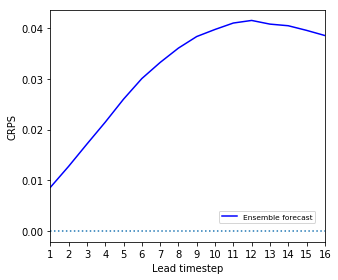

In [54]:
    ##############################################################################################################
    ###########       Compute CRPS with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    # Write CSV file
    with open(os.path.join(output_path, "CRPS_pred.csv"), "wt+") as fp:
        writer = csv.writer(fp, delimiter=",")
        writer.writerow(["BayesConvLSTM","CRPS","leadTime"])  # write header
        writer.writerow(np.arange(step_lead))  # write header
        writer.writerow(crps)
        
    index = np.arange(0, step_lead)
    
    fig10 = plt.figure()
    fig10.set_size_inches(4.8, 4, forward=True)
    # forecast
    plt.plot(np.arange(1,step_lead+1,1), crps[:], 'b', label='BayesConvLSTM')
    plt.axhline(y=0, ls = ':')
    plt.xticks(np.arange(1,step_lead+1,1))
    plt.xlim(1, 16)
    plt.ylabel("CRPS")
    plt.xlabel("Lead timestep")
    plt.legend(frameon=True, prop={'size': 7.5}, bbox_to_anchor=(0.6,0.065))
    
    plt.tight_layout()

    plt.show()
    fig10.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_CRPS.png'),dpi=120)